# Physics-Informed Neural Network for 1D Heat Equation

## Problem Setup
We solve: $\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$

 - **Forward Problem**: Given $\alpha$, find $u(x,t)$
 - **Inverse Problem**: Given measurements of $u$, find $\alpha$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from models.heat_pinn import HeatPINN
from results.plotter import plot_solution
from data.heat_data import HeatEquationData
from training.trainer import PINNTrainer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Imports successful.")

Imports successful.


## Step 1: Generate Data

Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 40.3 dB

Dataset generation complete.


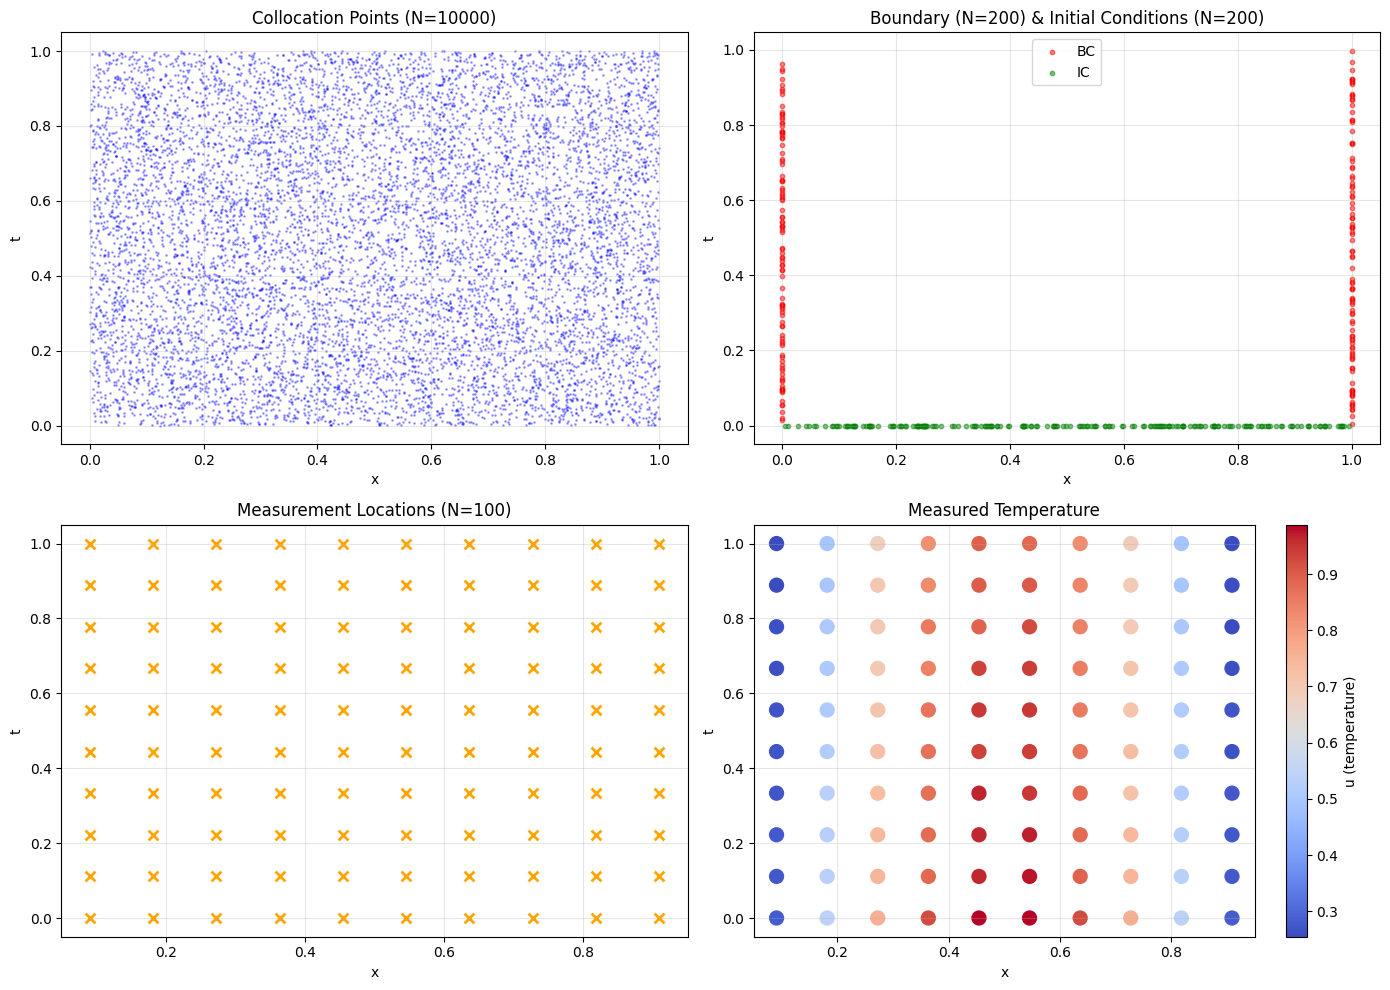

In [2]:
data_gen = HeatEquationData(
    L=1.0,                  # Domain length
    T=1.0,                  # Final time
    alpha=0.01,             # True thermal diffusivity
    N_f=10000,              # Collocation points
    N_bc = 100,             # BC points
    N_ic = 200,             # IC points
    N_sensors=10,           # Sensor locations
    N_time_measurements=10, # Time measurements
    noise_level=0.01,       # 1% noise (SNR ~ 40 dB)
    device='cpu'
)

# Generate complete dataset
data = data_gen.generate_full_dataset(collocation_method='uniform')

# Visualize the data
data_gen.visualize_data(data)

## Step 2: Train Forward Problem

Here we solve for $u(x,t)$ given known $\alpha = 0.01$

### Fixed weights *without* L-BFGS

In [3]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

print(f"Model parameters: {sum(p.numel() for p in model_forward.parameters())}")

Forward problem mode: alpha fixed to 0.01
Model parameters: 7851


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 1e-12
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.0s)
  Adam learning rate: 1.00e-03
  Total Loss: 7.799184e-01
  Residual: 3.642399e-04 (λ=1.00)
  Boundary: 4.342730e-02 (λ=1.00)
  Initial: 7.361268e-01 (λ=1.00)

Epoch 1000/5000 (51.3s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.935953e-04
  Residual: 1.056388e-04 (λ=1.00)
  Boundary: 6.532913e-05 (λ=1.00)
  Initial: 1.226274e-04 (λ=1.00)

Epoch 2000/5000 (102.3s)
  Adam learning rate: 1.00e-03
  Total Loss: 6.808015e-05
  Residual: 2.574606e-05 (λ=1.00)
  Boundary: 1.277820e-05 (λ=1.00)
  Initial: 2.955589e-05 (λ=1.00)


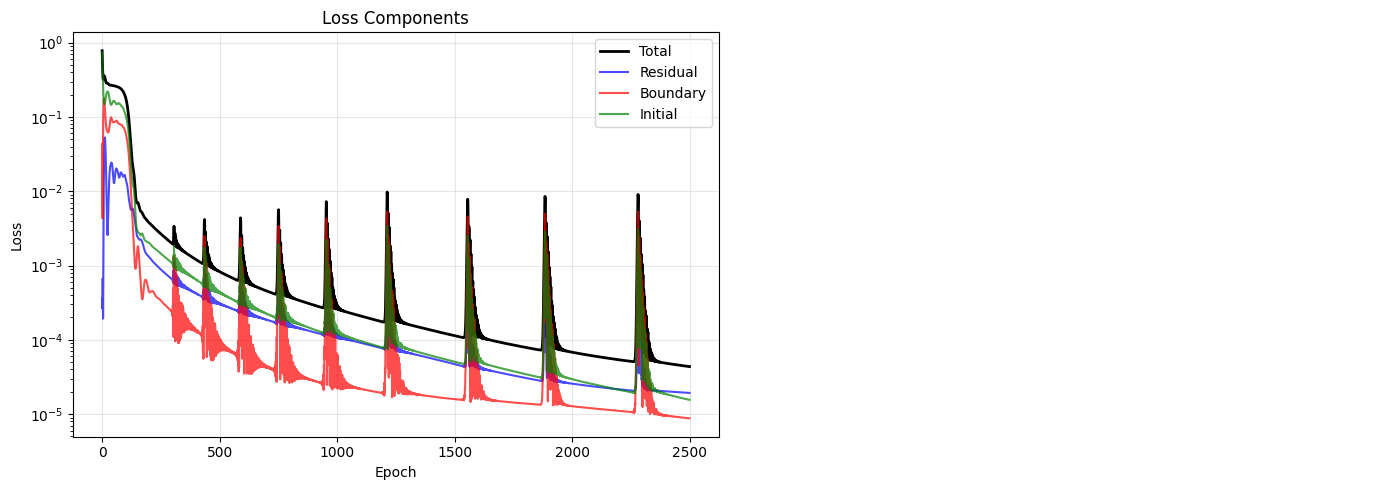


Epoch 3000/5000 (154.2s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.980997e-05
  Residual: 1.610084e-05 (λ=1.00)
  Boundary: 5.493638e-06 (λ=1.00)
  Initial: 8.215499e-06 (λ=1.00)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Epoch 4000/5000 (205.2s)
  Adam learning rate: 5.00e-04
  Total Loss: 1.786643e-05
  Residual: 1.229486e-05 (λ=1.00)
  Boundary: 2.421669e-06 (λ=1.00)
  Initial: 3.149902e-06 (λ=1.00)

Final training plot:


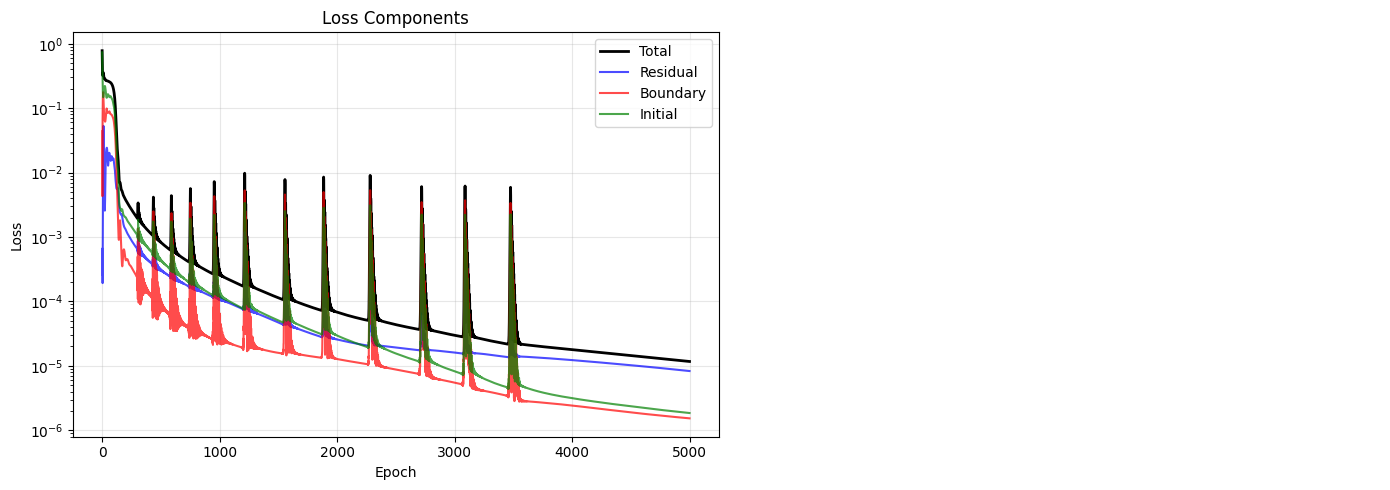


Training complete. Total time: 257.1s


In [5]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    switch_var=1e-12,       # very low = disabled
    switch_slope=1e-12,     # very low = disabled
    adaptive_weights=False,
)

# Train for 5000 epochs
trainer_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Visualize

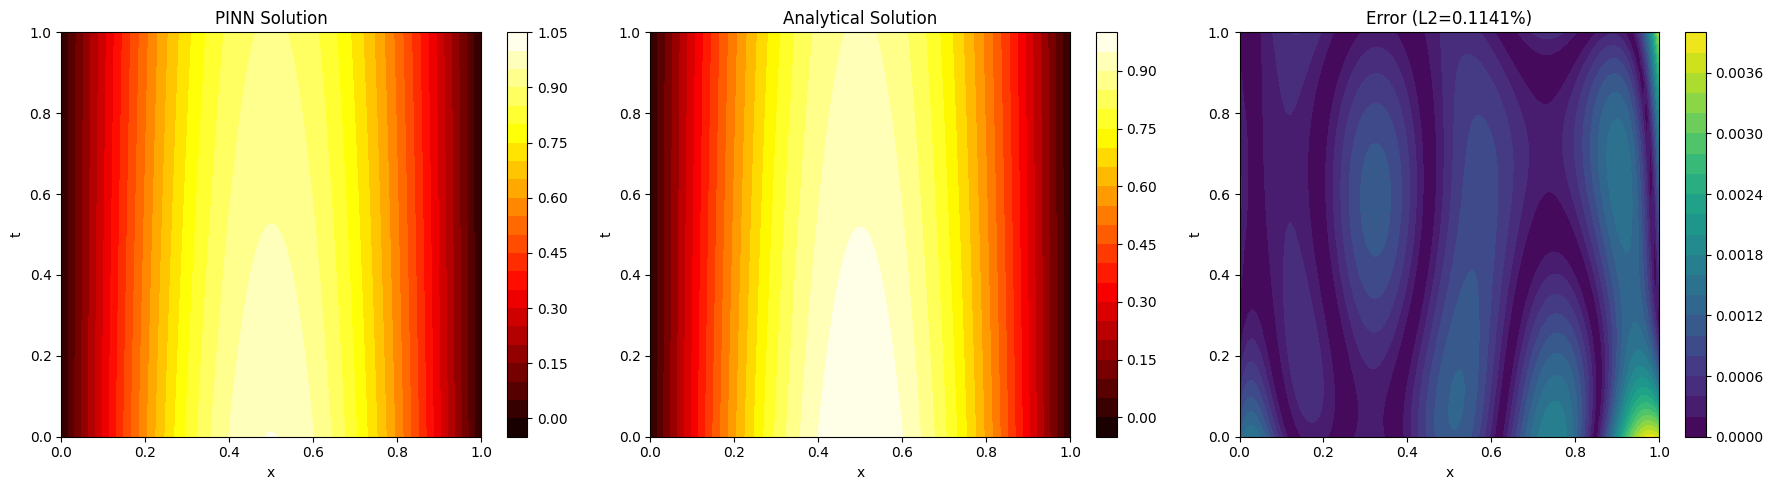

In [6]:
plot_solution(model_forward, data, alpha_true=0.01, save_path='../results/forward_5k_no_aw_reconstruct.png')

### Fixed weights with L-BFGS

In [ ]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

Forward problem mode: alpha fixed to 0.01
Model parameters: 7851


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 8.925540e-01
  Residual: 7.416567e-02 (λ=1.00)
  Boundary: 9.310022e-02 (λ=1.00)
  Initial: 7.252881e-01 (λ=1.00)

Epoch 1000/5000 (51.7s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.831818e-04
  Residual: 7.518109e-05 (λ=1.00)
  Boundary: 4.075795e-05 (λ=1.00)
  Initial: 1.672428e-04 (λ=1.00)

Epoch 2000/5000 (103.6s)
  Adam learning rate: 1.00e-03
  Total Loss: 3.484791e-05
  Residual: 1.877177e-05 (λ=1.00)
  Boundary: 7.055017e-06 (λ=1.00)
  Initial: 9.021123e-06 (λ=1.00)


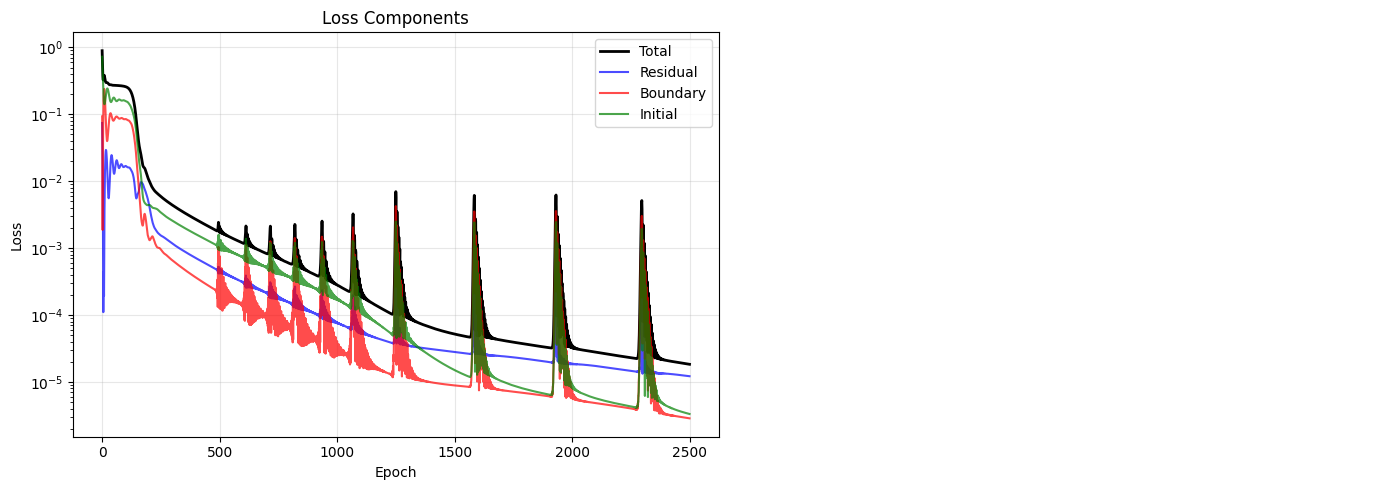


Adam LR reduced: 1.00e-03 -> 5.00e-04

Epoch 3000/5000 (156.2s)
  Adam learning rate: 5.00e-04
  Total Loss: 1.335086e-05
  Residual: 9.469396e-06 (λ=1.00)
  Boundary: 1.766413e-06 (λ=1.00)
  Initial: 2.115051e-06 (λ=1.00)

Switching to L-BFGS at epoch 3079
  Variance ratio: 0.099966 < 0.1
  Slope (log): |-0.000588| < 0.001

Final training plot:


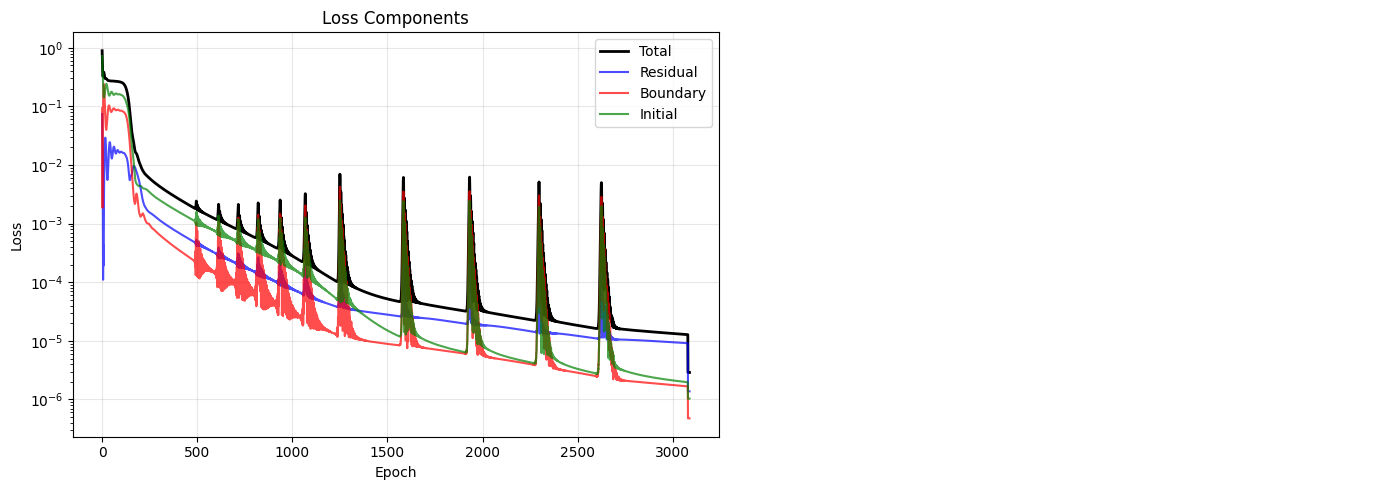


Training complete. Total time: 166.1s


In [8]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=False,
)

# Train for 5000 epochs
trainer_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Visualize

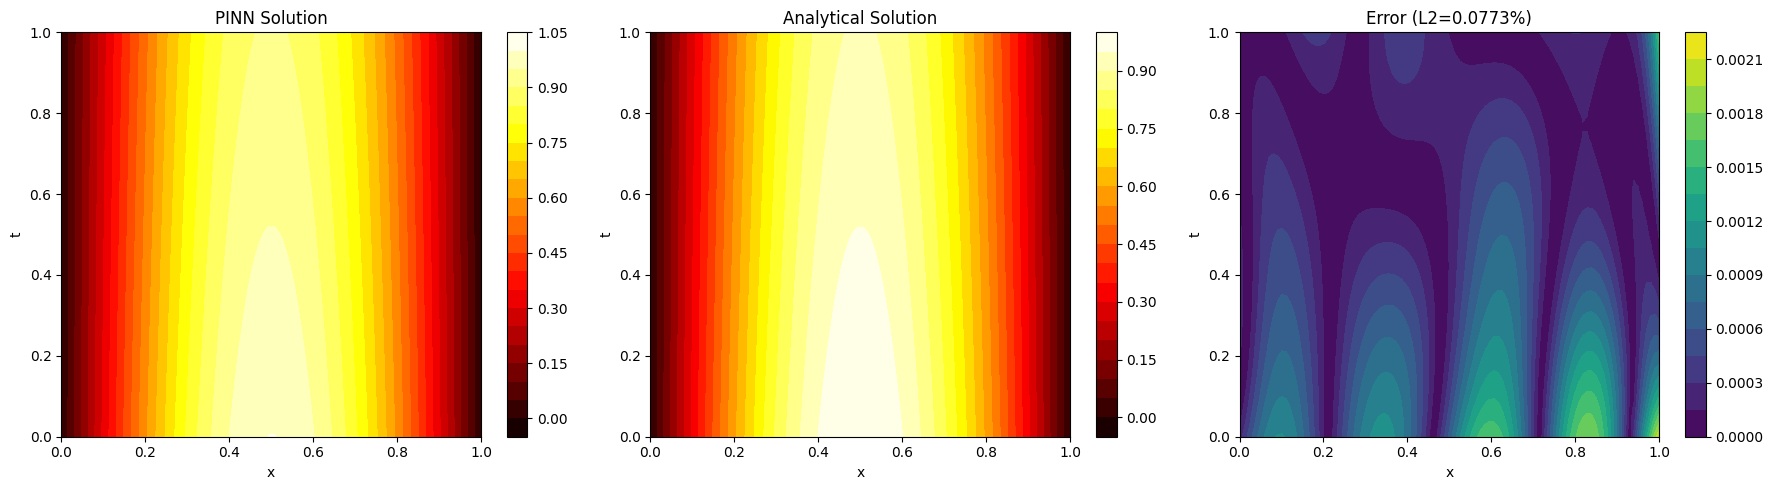

In [9]:
plot_solution(model_forward, data, alpha_true=0.01, save_path='../results/forward_5k_no_aw_lbfgs_reconstruct.png')

### Advantage of L-BFGS

We train the same model with Adam up to the epoch where L-BFGS kicked in and compare the prediction errors

In [ ]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

Forward problem mode: alpha fixed to 0.01
Model parameters: 7851


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 1e-12
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/3080 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 7.230464e-01
  Residual: 1.001111e-04 (λ=1.00)
  Boundary: 2.650975e-02 (λ=1.00)
  Initial: 6.964365e-01 (λ=1.00)

Epoch 500/3080 (25.3s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.324155e-03
  Residual: 5.300161e-04 (λ=1.00)
  Boundary: 1.494632e-04 (λ=1.00)
  Initial: 6.446759e-04 (λ=1.00)

Epoch 1000/3080 (49.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 5.734633e-04
  Residual: 2.230288e-04 (λ=1.00)
  Boundary: 1.344137e-04 (λ=1.00)
  Initial: 2.160207e-04 (λ=1.00)


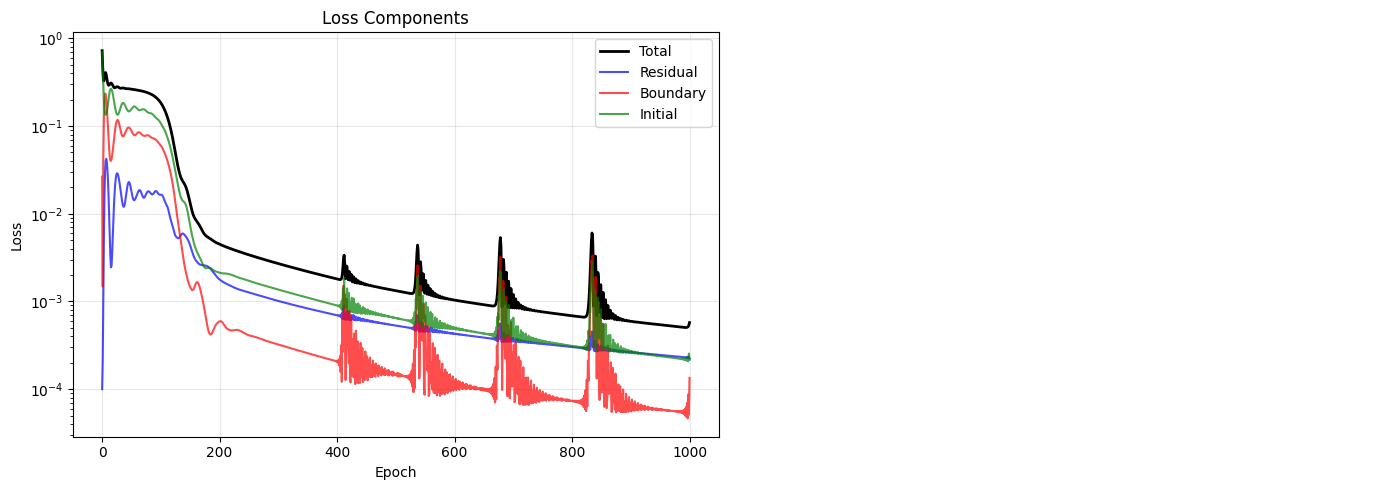


Epoch 1500/3080 (72.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 3.610686e-04
  Residual: 1.365487e-04 (λ=1.00)
  Boundary: 6.309697e-05 (λ=1.00)
  Initial: 1.614230e-04 (λ=1.00)

Epoch 2000/3080 (94.8s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.806109e-04
  Residual: 8.385160e-05 (λ=1.00)
  Boundary: 2.483928e-05 (λ=1.00)
  Initial: 7.192000e-05 (λ=1.00)


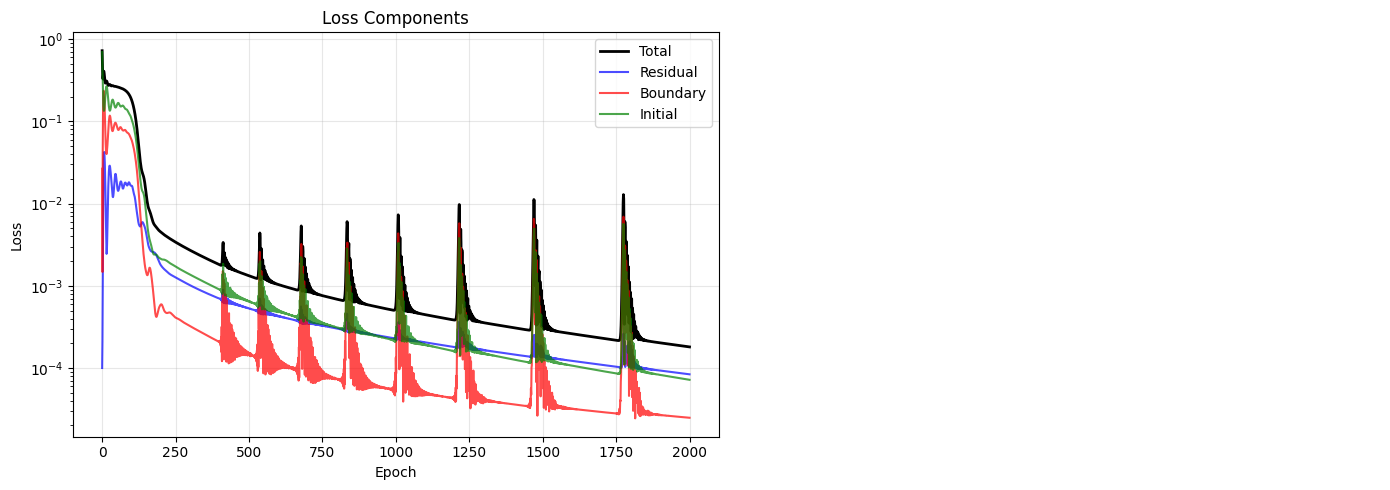


Adam LR reduced: 1.00e-03 -> 5.00e-04

Epoch 2500/3080 (119.4s)
  Adam learning rate: 5.00e-04
  Total Loss: 1.358226e-04
  Residual: 6.091394e-05 (λ=1.00)
  Boundary: 2.076156e-05 (λ=1.00)
  Initial: 5.414712e-05 (λ=1.00)

Epoch 3000/3080 (142.8s)
  Adam learning rate: 5.00e-04
  Total Loss: 1.010268e-04
  Residual: 4.467440e-05 (λ=1.00)
  Boundary: 1.759809e-05 (λ=1.00)
  Initial: 3.875434e-05 (λ=1.00)


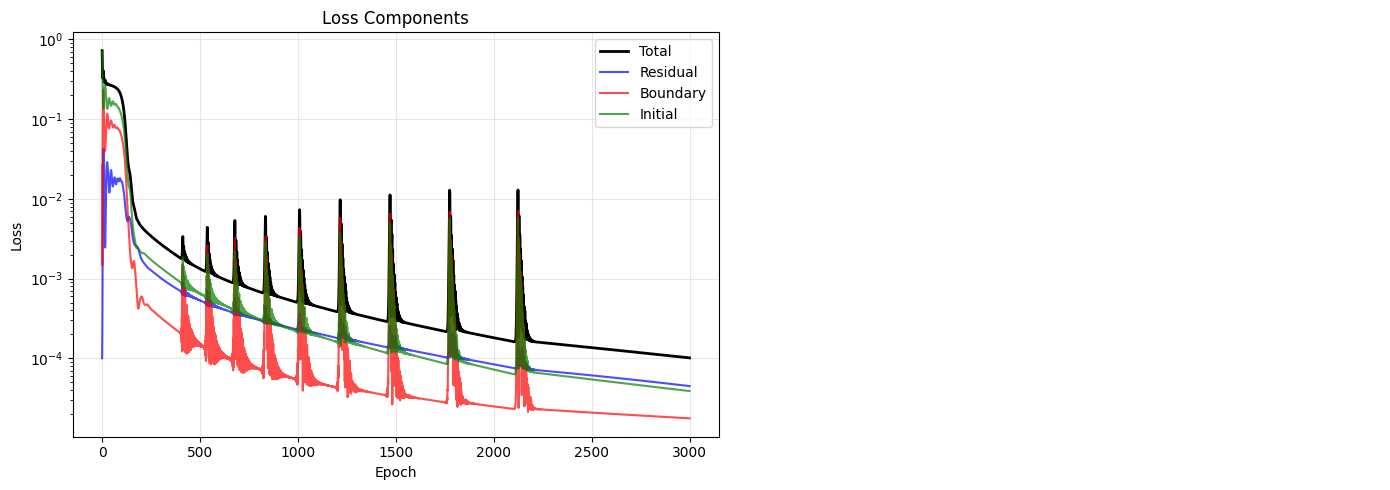


Final training plot:


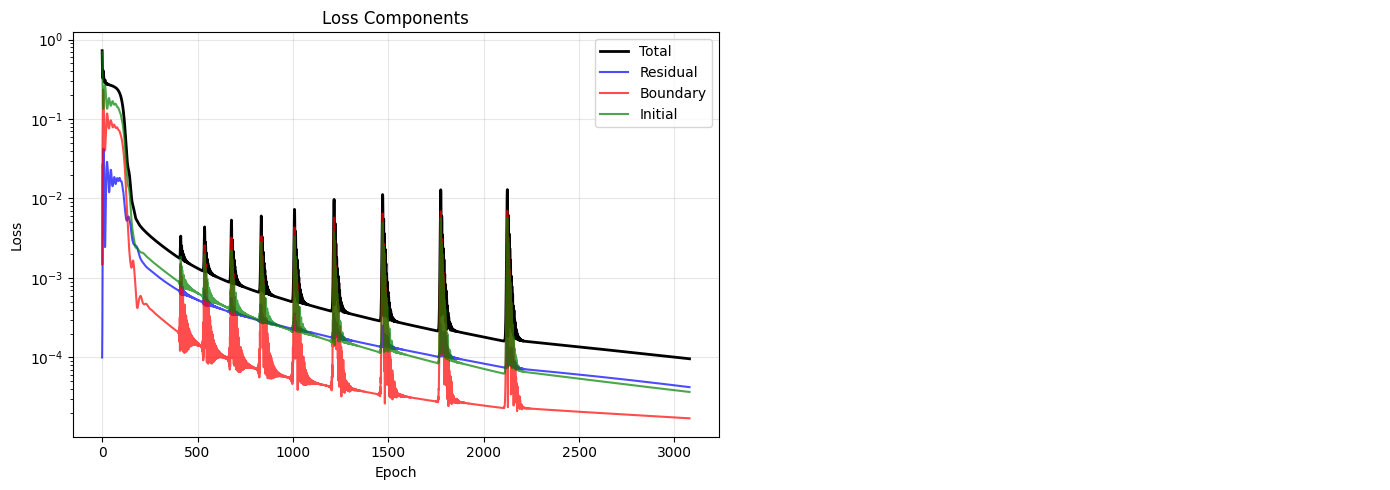


Training complete. Total time: 147.6s


In [11]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    switch_var=1e-12,
    switch_slope=1e-12,
    adaptive_weights=False,
)

# Train for L-BFGS epochs
trainer_forward.train(
    epochs=3080,
    print_every=500,
    plot_every=1000
)

Visualize

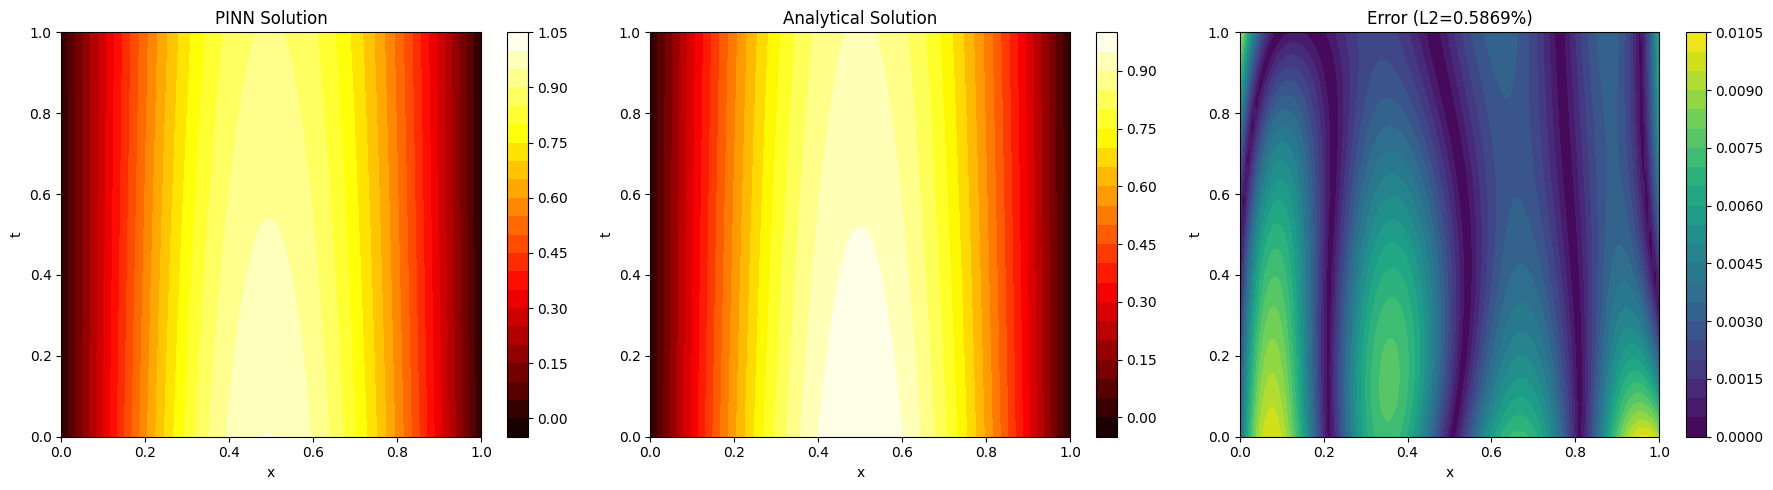

In [12]:
plot_solution(model_forward, data, alpha_true=0.01)

**Conclusion**: L-BFGS improves the L2 error of the solution by a factor of $\approx 8$ for the same training time!

### Identifying the cause of spikes

The training loss curves display spikes when the optimizer starts probing high-curvature regions of the parameter landscape (weight, bias). In these regions the losses increase, which causes the optimizer to steer away from them.

These high-curvature regions are related to high eigenvalues of the losses' Hessian matrix, which can be inferred from the presence of spikes in the loss gradients.

In [ ]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

Forward problem mode: alpha fixed to 0.01
Model parameters: 7851


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 1e-12
  Tracking gradient L2 norms: True
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/2000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 5.319207e-01
  Residual: 9.473966e-06 (λ=1.00)
  Boundary: 3.576551e-04 (λ=1.00)
  Initial: 5.315536e-01 (λ=1.00)

Epoch 1000/2000 (103.3s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.325854e-04
  Residual: 6.363541e-05 (λ=1.00)
  Boundary: 1.286716e-05 (λ=1.00)
  Initial: 5.608285e-05 (λ=1.00)


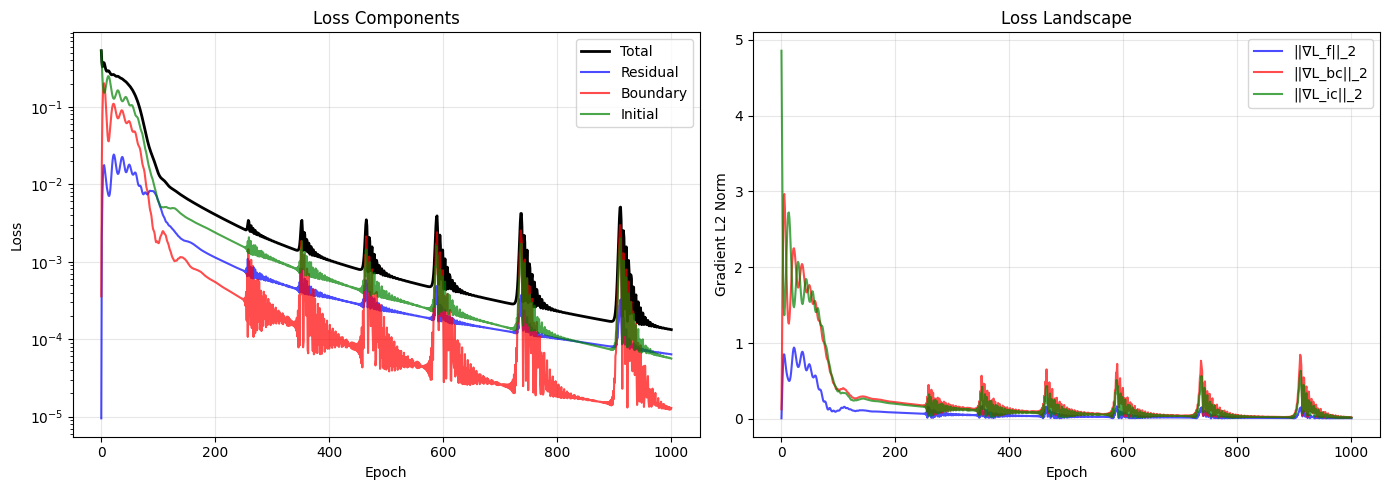


Final training plot:


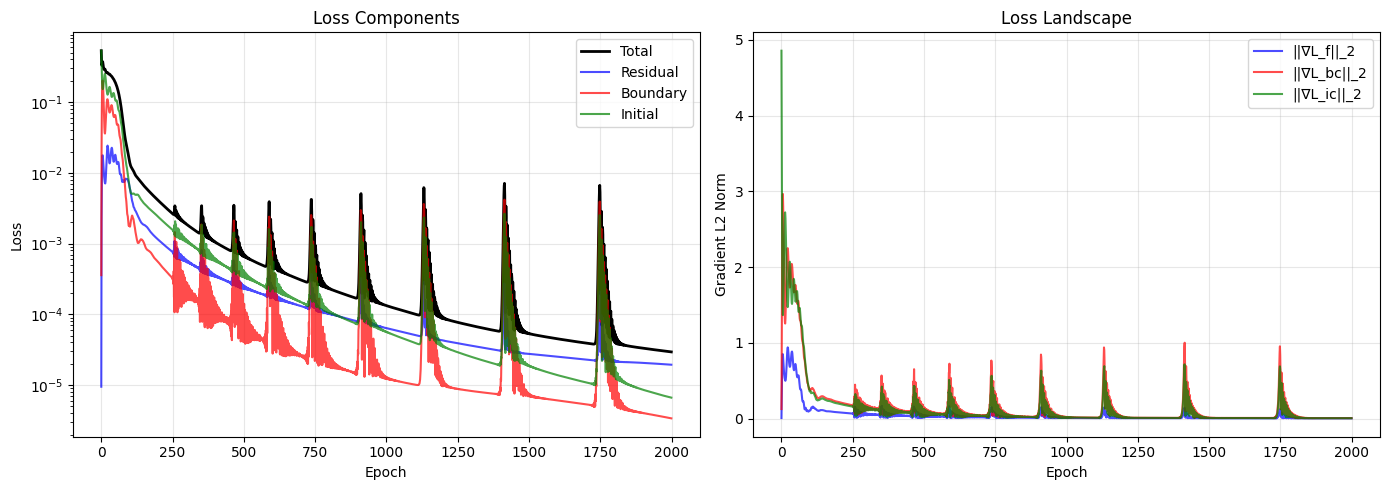


Training complete. Total time: 199.6s


In [15]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_var=1e-12,
    switch_slope=1e-12,
    track_gradient_norms=True,
    adaptive_weights=False,
)

# Train for 2000 epochs
trainer_forward.train(
    epochs=2000,
    print_every=1000,
    plot_every=1000
)

### Effect of adaptive weights

In [16]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

Forward problem mode: alpha fixed to 0.01


We use L-BFGS since it has proven effective

Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 6.025344e-01
  Residual: 1.733574e-02 (λ=1.00)
  Boundary: 4.391146e-03 (λ=1.00)
  Initial: 5.808074e-01 (λ=1.00)

Epoch 1000/5000 (48.7s)
  Adam learning rate: 1.00e-03
  Total Loss: 8.857032e-05
  Residual: 1.209106e-05 (λ=3.80)
  Boundary: 2.945213e-05 (λ=0.72)
  Initial: 2.888310e-05 (λ=0.74)

Epoch 2000/5000 (97.9s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.512722e-05
  Residual: 4.300696e-06 (λ=3.62)
  Boundary: 9.453420e-06 (λ=0.70)
  Initial: 3.788787e-06 (λ=0.77)


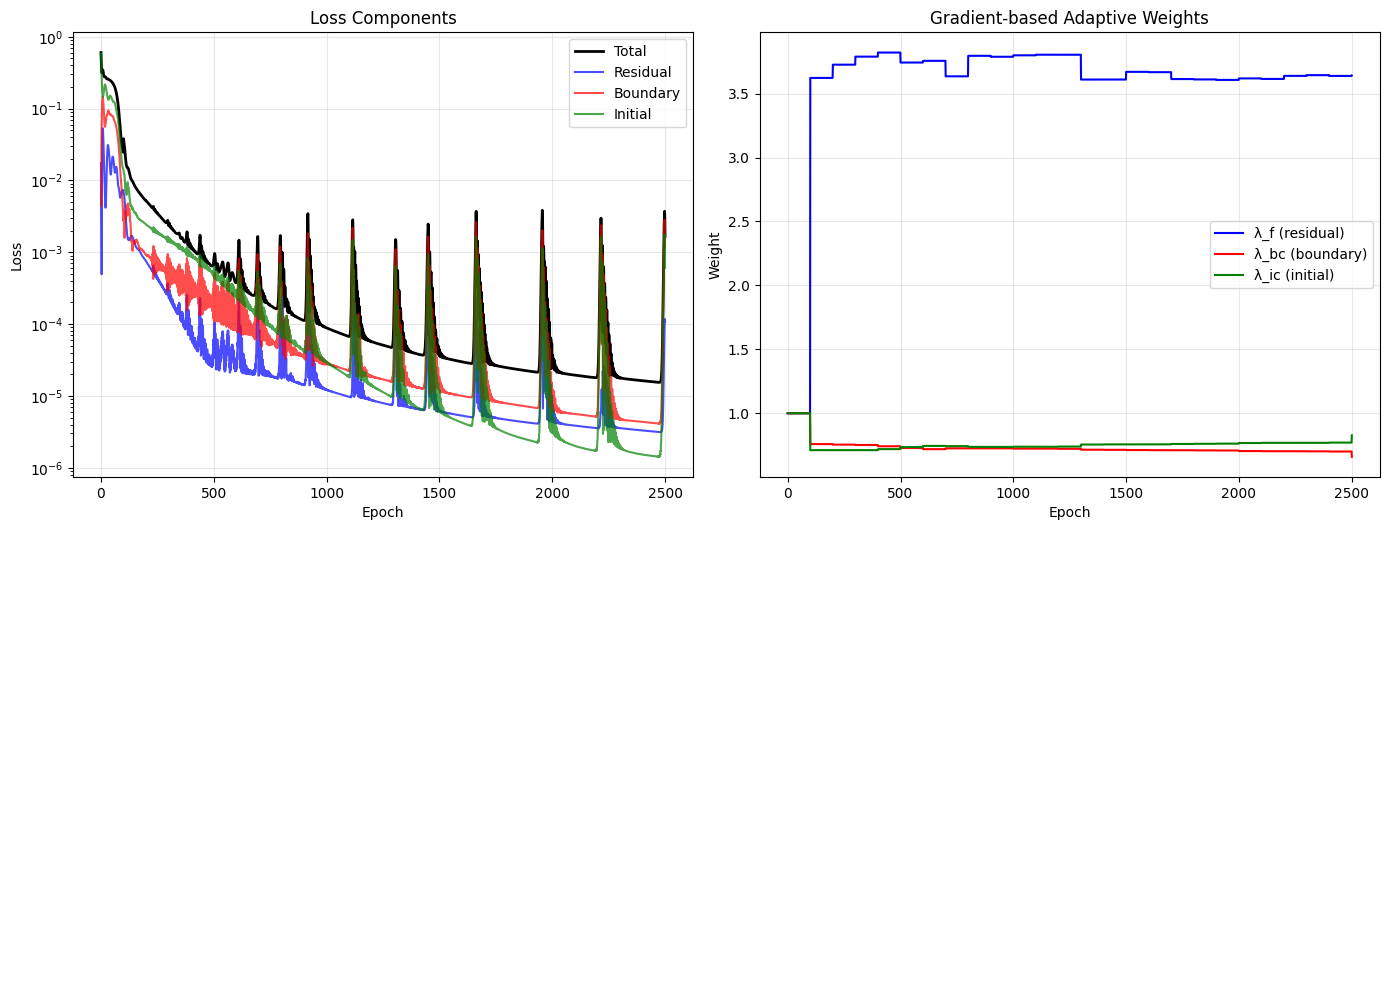


Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 2762
  Variance ratio: 0.099522 < 0.1
  Slope (log): |-0.000586| < 0.001

Final training plot:


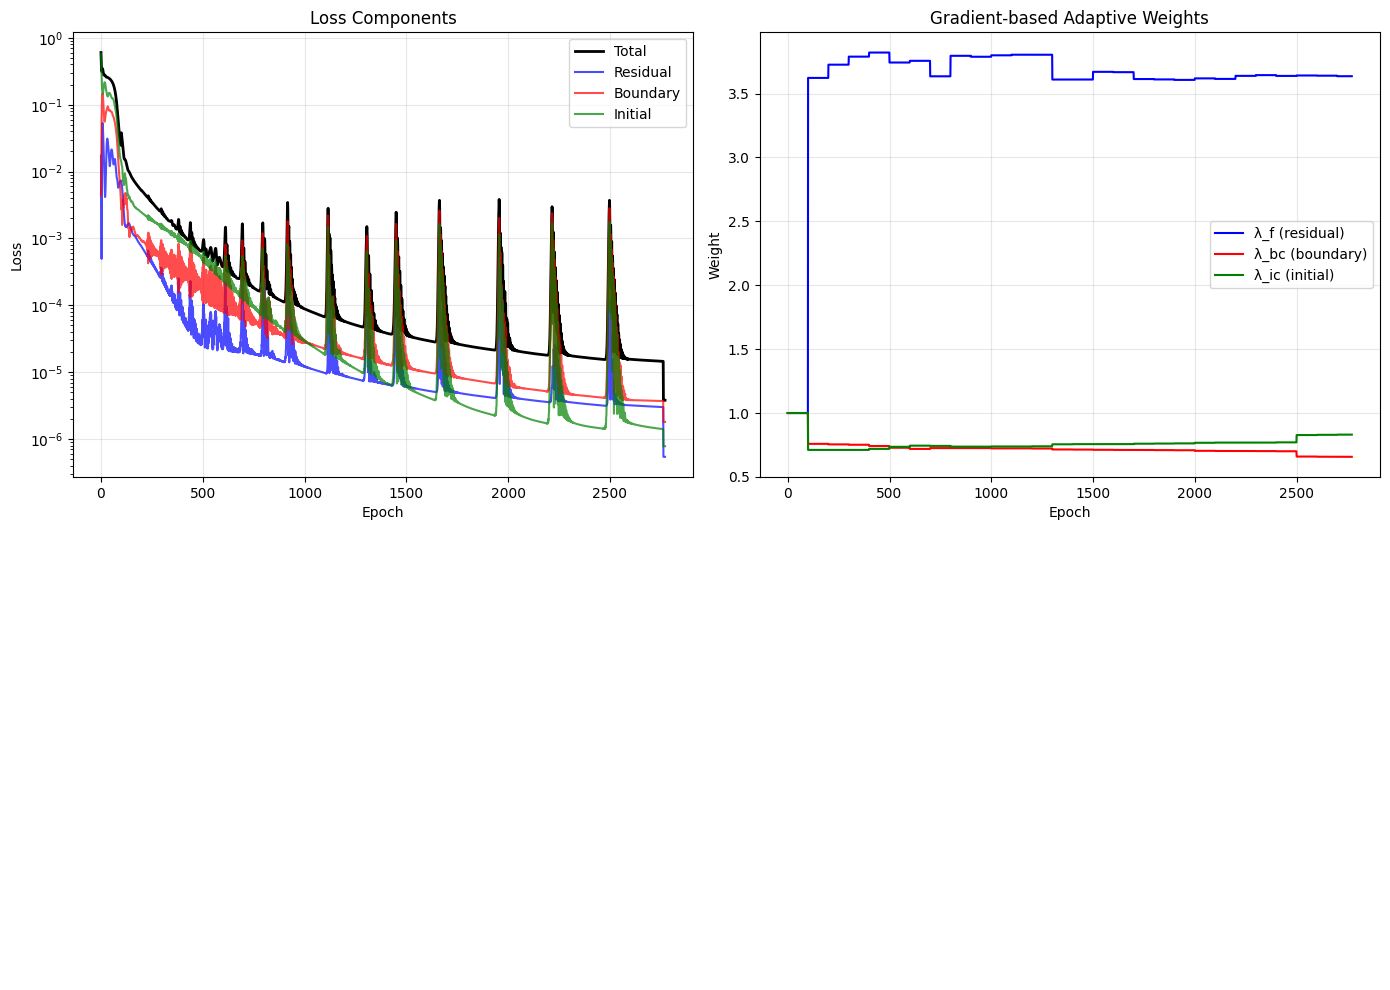


Training complete. Total time: 143.3s


In [17]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_var=0.1,
    switch_slope=0.001,
    track_gradient_norms=False,
    adaptive_weights=True,
)

# Train for 5000 epochs
trainer_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Visualize

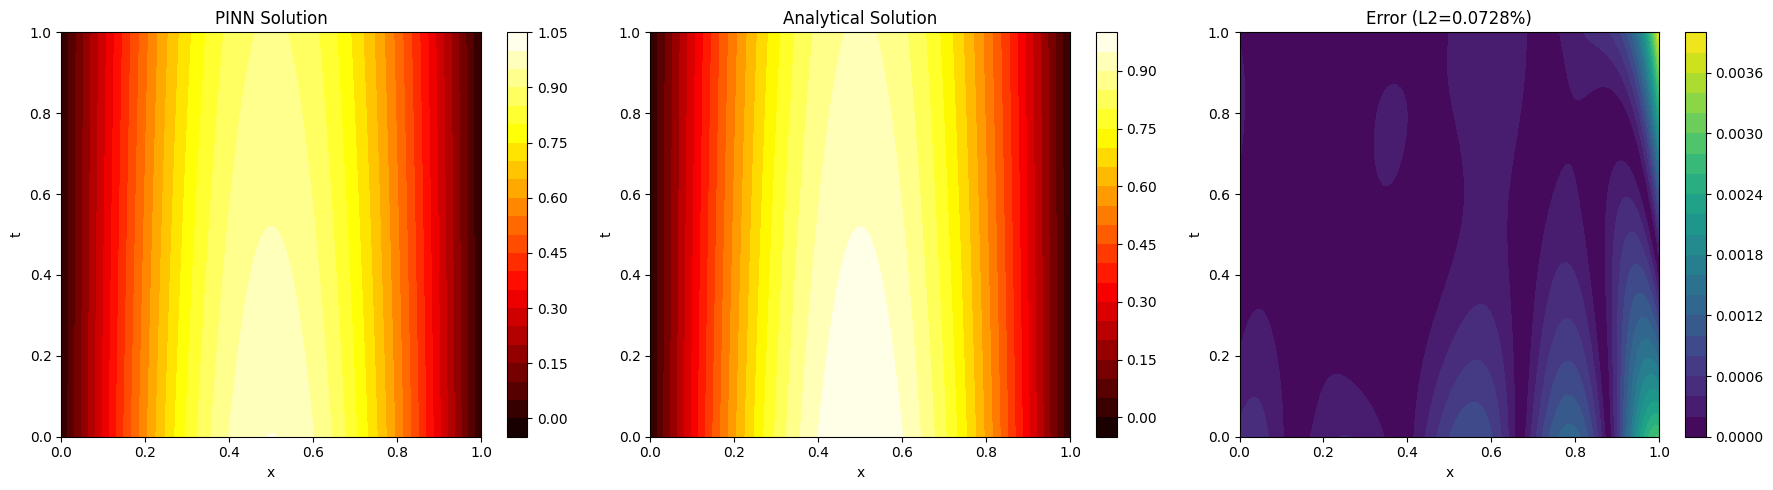

In [18]:
plot_solution(model_forward, data, alpha_true=0.01, save_path='../results/forward_5k_aw_lbfgs_reconstruct')

**Conclusion**: adaptive weights help, but only a little. This is likely due to the fact that the PDE is smooth and does not display multi-scale or high-frequency features.

## Step 3: Train Inverse Problem

Now we recover $\alpha$ from noisy measurements of $u(x,t)$

### Fixed weights without L-BFGS

In [3]:
model_inverse = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02  # Initial guess
)

Inverse problem mode: alpha initialized to 0.02


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 1e-12
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.521870e+00
  Residual: 3.763747e-04 (λ=1.00)
  Boundary: 4.342730e-02 (λ=1.00)
  Initial: 7.361268e-01 (λ=1.00)
  Measurement: 7.419395e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Epoch 1000/5000 (48.6s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.648523e-03
  Residual: 1.944977e-04 (λ=1.00)
  Boundary: 6.640962e-04 (λ=1.00)
  Initial: 2.664955e-04 (λ=1.00)
  Measurement: 5.234336e-04 (λ=1.00)
  Alpha: 0.009112 (true: 0.01)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Epoch 2000/5000 (99.7s)
  Adam learning rate: 5.00e-04
  Total Loss: 2.274236e-04
  Residual: 7.987445e-05 (λ=1.00)
  Boundary: 1.909123e-05 (λ=1.00)
  Initial: 4.801239e-05 (λ=1.00)
  Measurement: 8.044554e-05 (λ=1.00)
  Alpha: 0.009490 (true: 0.

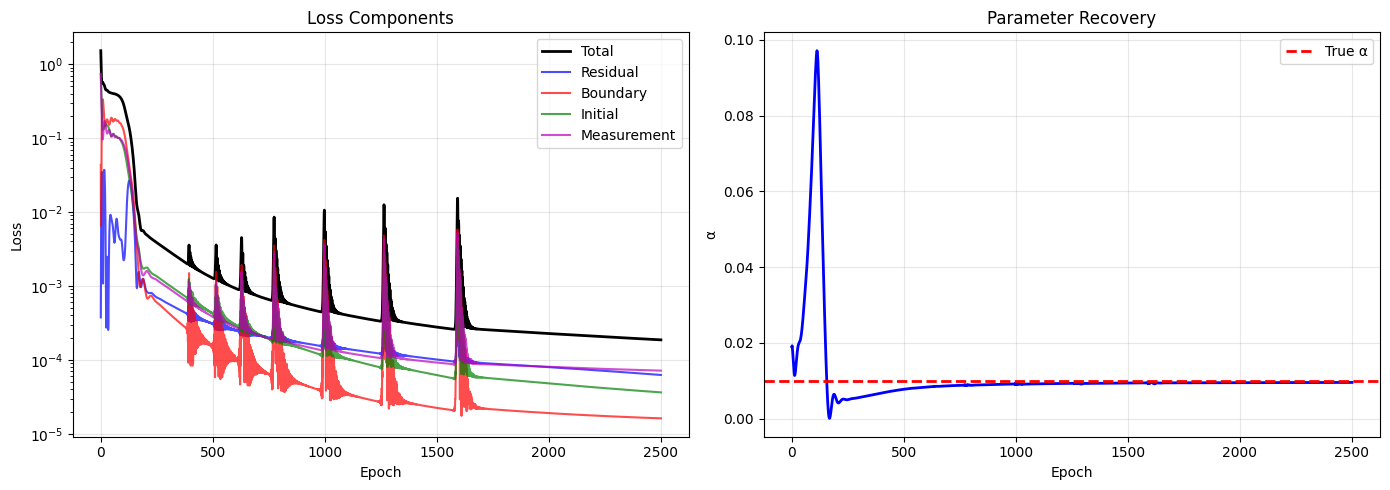


Epoch 3000/5000 (155.8s)
  Adam learning rate: 5.00e-04
  Total Loss: 1.561387e-04
  Residual: 4.659890e-05 (λ=1.00)
  Boundary: 1.474365e-05 (λ=1.00)
  Initial: 2.900304e-05 (λ=1.00)
  Measurement: 6.579315e-05 (λ=1.00)
  Alpha: 0.009603 (true: 0.01)

Epoch 4000/5000 (207.1s)
  Adam learning rate: 5.00e-04
  Total Loss: 1.164391e-04
  Residual: 2.454055e-05 (λ=1.00)
  Boundary: 1.228696e-05 (λ=1.00)
  Initial: 2.064732e-05 (λ=1.00)
  Measurement: 5.896431e-05 (λ=1.00)
  Alpha: 0.009724 (true: 0.01)

Final training plot:


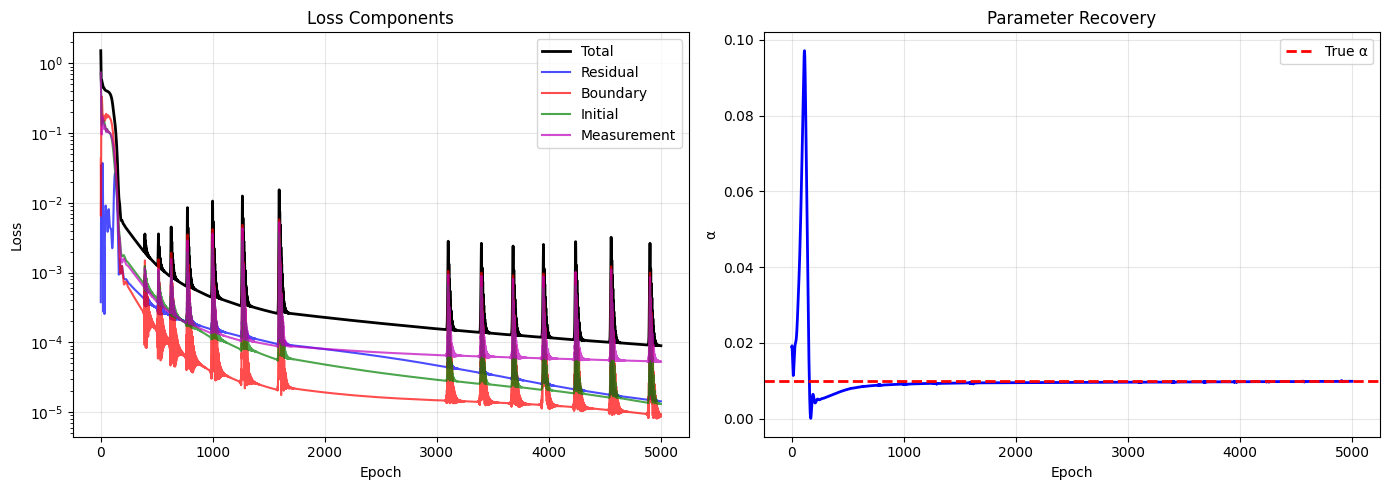


Training complete. Total time: 259.3s


In [4]:
trainer_inverse = PINNTrainer(
    model=model_inverse,
    data=data,
    device='cpu',
    switch_var=1e-12,
    switch_slope=1e-12,
    adaptive_weights=False,
)

trainer_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate performance

In [5]:
alpha_true = 0.01
alpha_pred = model_inverse.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.009852
Error:         1.48%
SUCCESS: Parameter recovered within 5% error!


Visualize

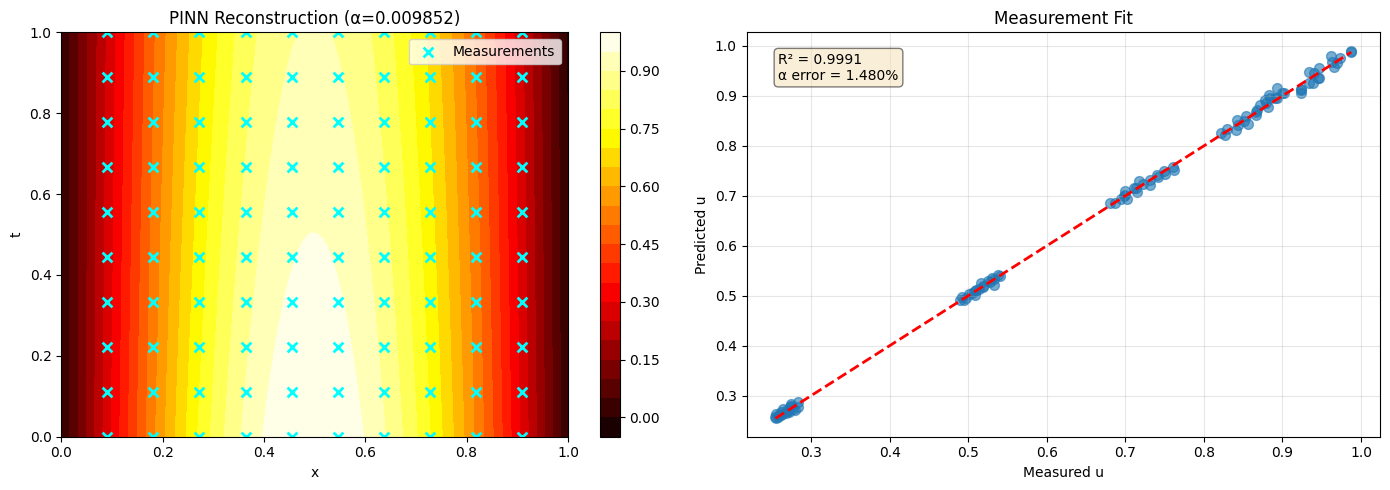

In [6]:
plot_solution(model_inverse, data, alpha_true=0.01, save_path='../results/inverse_5k_no_aw_reconstruct.png')

### Fixed weights with L-BFGS

In [7]:
model_inverse = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02
)

Inverse problem mode: alpha initialized to 0.02


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.859711e+00
  Residual: 7.468721e-02 (λ=1.00)
  Boundary: 9.310022e-02 (λ=1.00)
  Initial: 7.252881e-01 (λ=1.00)
  Measurement: 9.666353e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Epoch 1000/5000 (60.4s)
  Adam learning rate: 1.00e-03
  Total Loss: 9.169530e-04
  Residual: 1.900804e-04 (λ=1.00)
  Boundary: 1.054514e-04 (λ=1.00)
  Initial: 3.244949e-04 (λ=1.00)
  Measurement: 2.969263e-04 (λ=1.00)
  Alpha: 0.008077 (true: 0.01)

Epoch 2000/5000 (112.4s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.927472e-04
  Residual: 5.052484e-05 (λ=1.00)
  Boundary: 1.696081e-05 (λ=1.00)
  Initial: 5.037753e-05 (λ=1.00)
  Measurement: 7.488407e-05 (λ=1.00)
  Alpha: 0.009583 (true: 0.01)


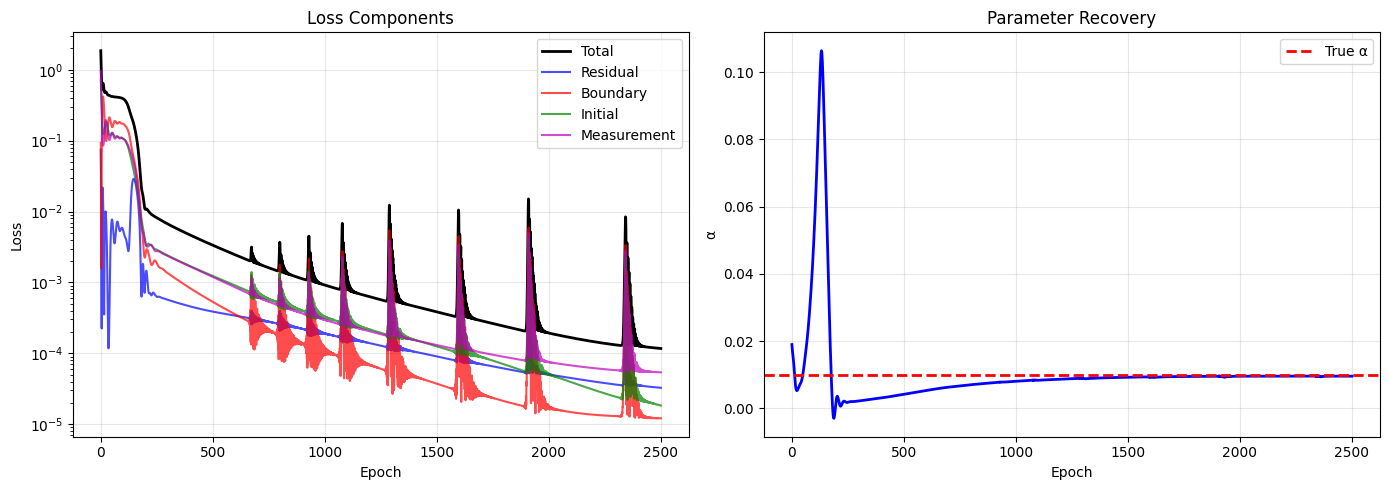


Switching to L-BFGS at epoch 2661
  Variance ratio: 0.099982 < 0.1
  Slope (log): |-0.000587| < 0.001

Final training plot:


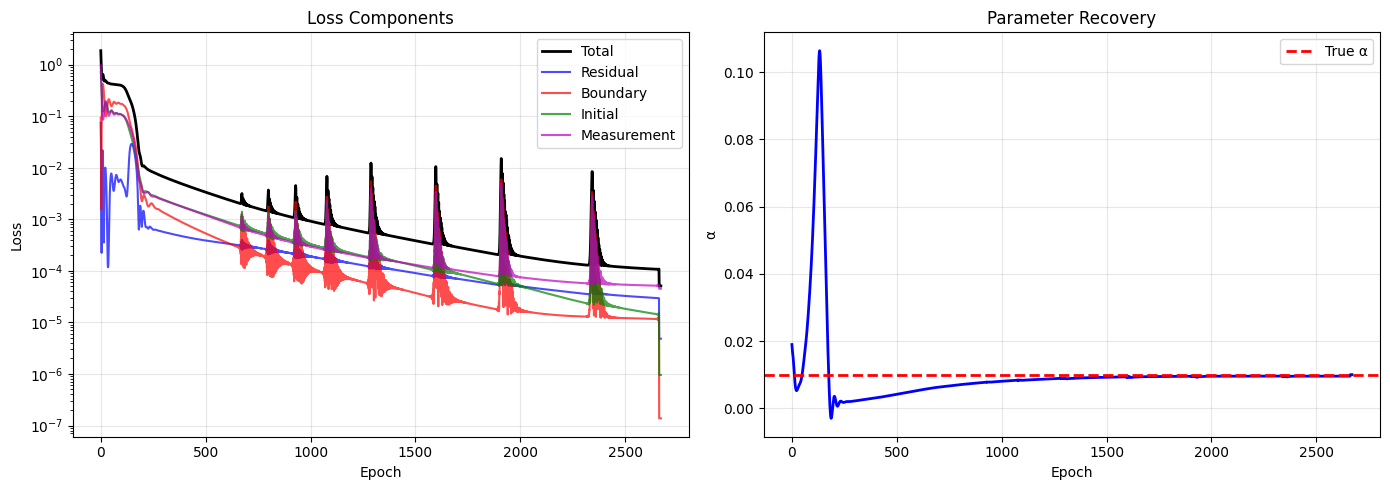


Training complete. Total time: 155.1s


In [9]:
trainer_inverse = PINNTrainer(
    model=model_inverse,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=False,
)

trainer_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate inverse problem

In [10]:
alpha_true = 0.01
alpha_pred = model_inverse.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.010049
Error:         0.49%
SUCCESS: Parameter recovered within 5% error!


Visualize inverse problem results

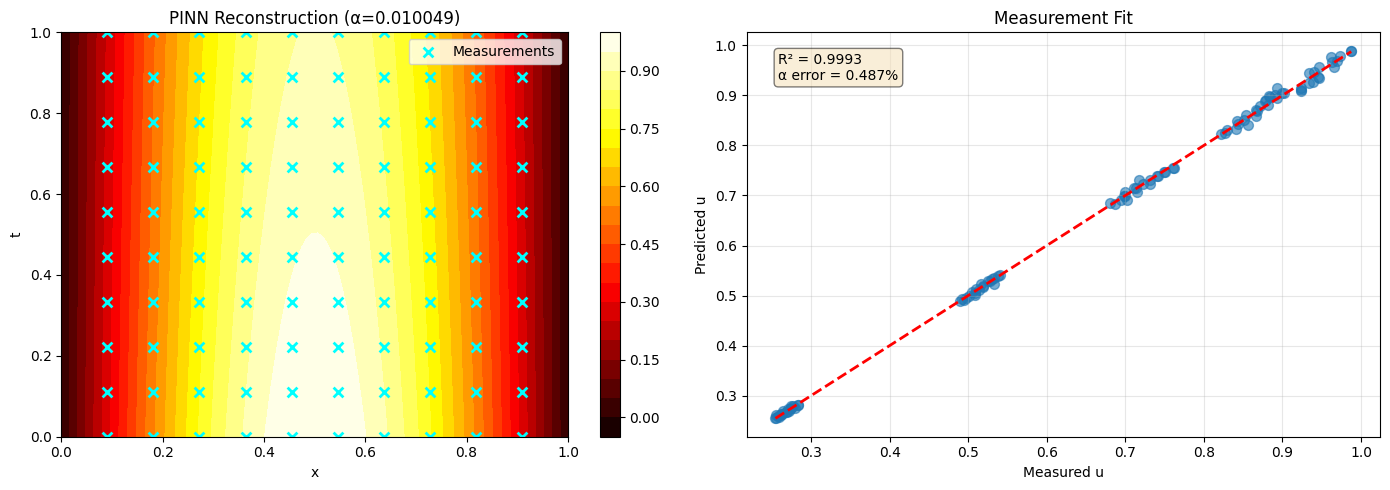

In [11]:
plot_solution(model_inverse, data, alpha_true=0.01, save_path='../results/inverse_5k_no_aw_lbfgs_reconstruct.png')

### Adaptive weight with L-BFGS

In [12]:
model_inverse = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02
)

Inverse problem mode: alpha initialized to 0.02


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.410208e+00
  Residual: 1.028557e-04 (λ=1.00)
  Boundary: 2.650975e-02 (λ=1.00)
  Initial: 6.964365e-01 (λ=1.00)
  Measurement: 6.871588e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Epoch 1000/5000 (53.6s)
  Adam learning rate: 1.00e-03
  Total Loss: 4.953695e-03
  Residual: 5.317167e-04 (λ=4.94)
  Boundary: 4.283407e-04 (λ=0.53)
  Initial: 1.092270e-03 (λ=1.28)
  Measurement: 7.920847e-04 (λ=0.89)
  Alpha: 0.004693 (true: 0.01)

Epoch 2000/5000 (100.3s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.124717e-03
  Residual: 6.183523e-05 (λ=4.18)
  Boundary: 3.206230e-04 (λ=0.57)
  Initial: 3.838172e-04 (λ=1.14)
  Measurement: 2.778086e-04 (λ=0.89)
  Alpha: 0

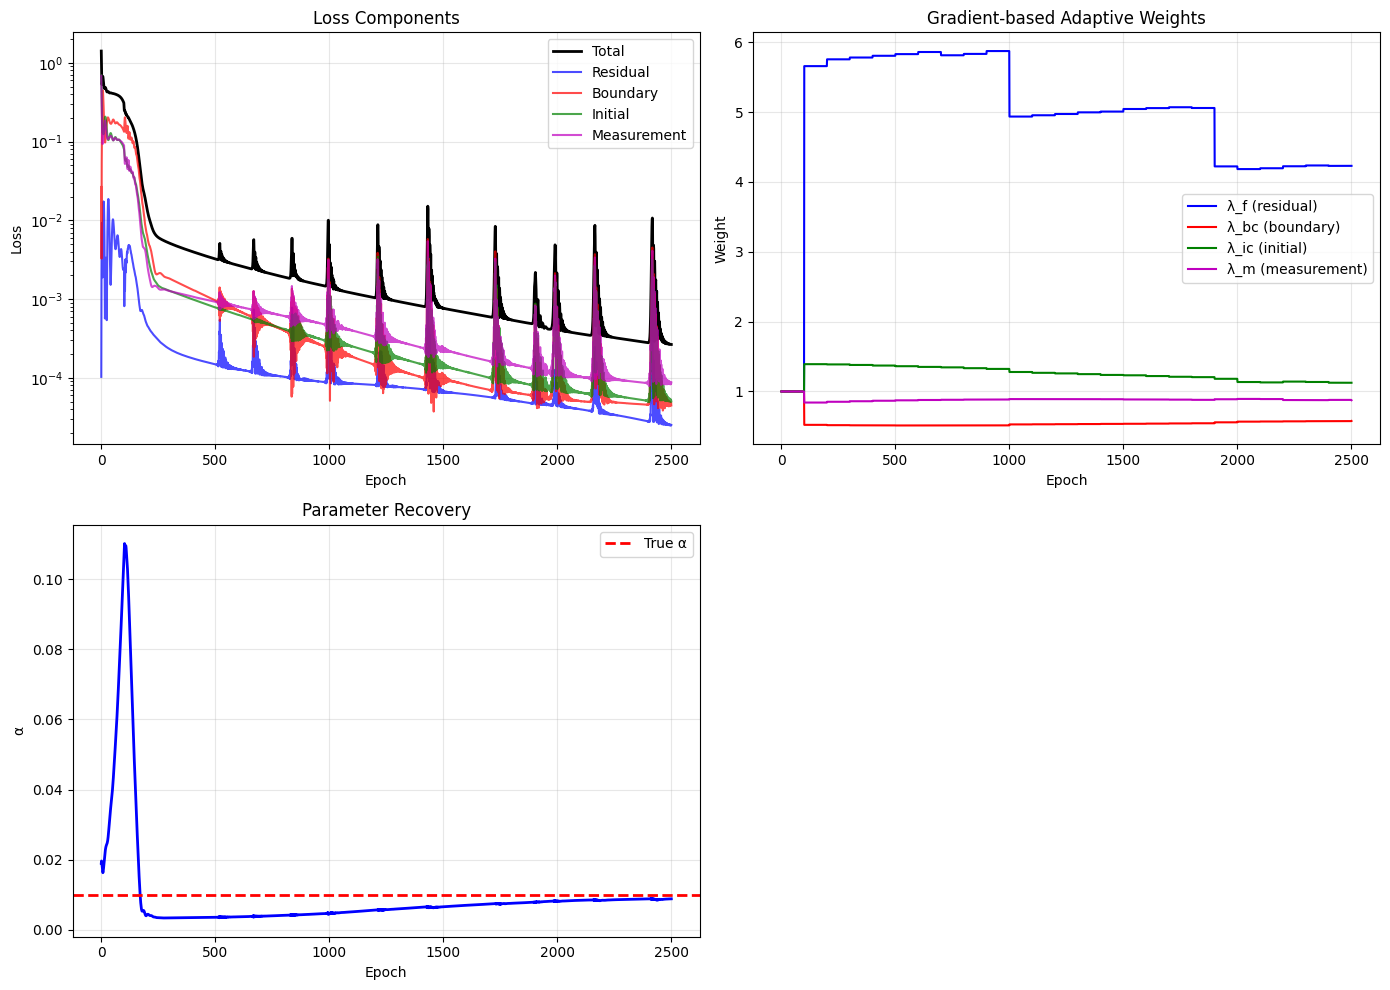


Epoch 3000/5000 (148.6s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.758802e-04
  Residual: 1.170885e-05 (λ=4.30)
  Boundary: 4.105435e-05 (λ=0.58)
  Initial: 3.734994e-05 (λ=1.10)
  Measurement: 6.902409e-05 (λ=0.88)
  Alpha: 0.009281 (true: 0.01)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 3866
  Variance ratio: 0.095163 < 0.1
  Slope (log): |-0.000508| < 0.001

Final training plot:


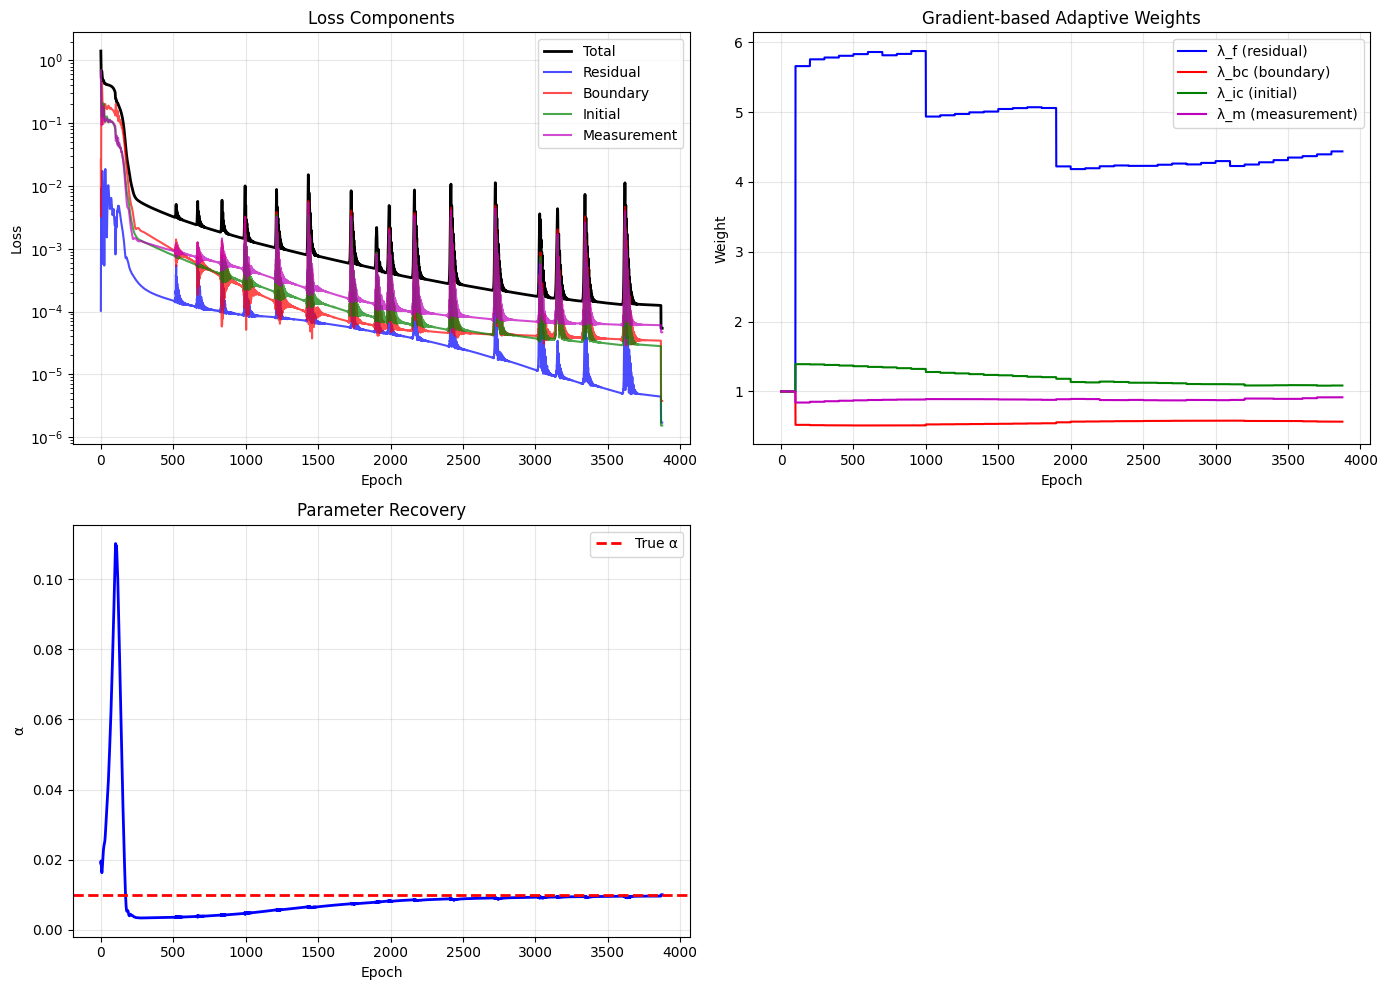


Training complete. Total time: 198.6s


In [14]:
trainer_inverse = PINNTrainer(
    model=model_inverse,
    data=data,
    device='cpu',
    switch_var=0.1,
    switch_slope=0.001,
    adaptive_weights=True,
)

# Inverse problems typically need more epochs
trainer_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate

In [15]:
alpha_true = 0.01
alpha_pred = model_inverse.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.010012
Error:         0.12%
SUCCESS: Parameter recovered within 5% error!


Visualize

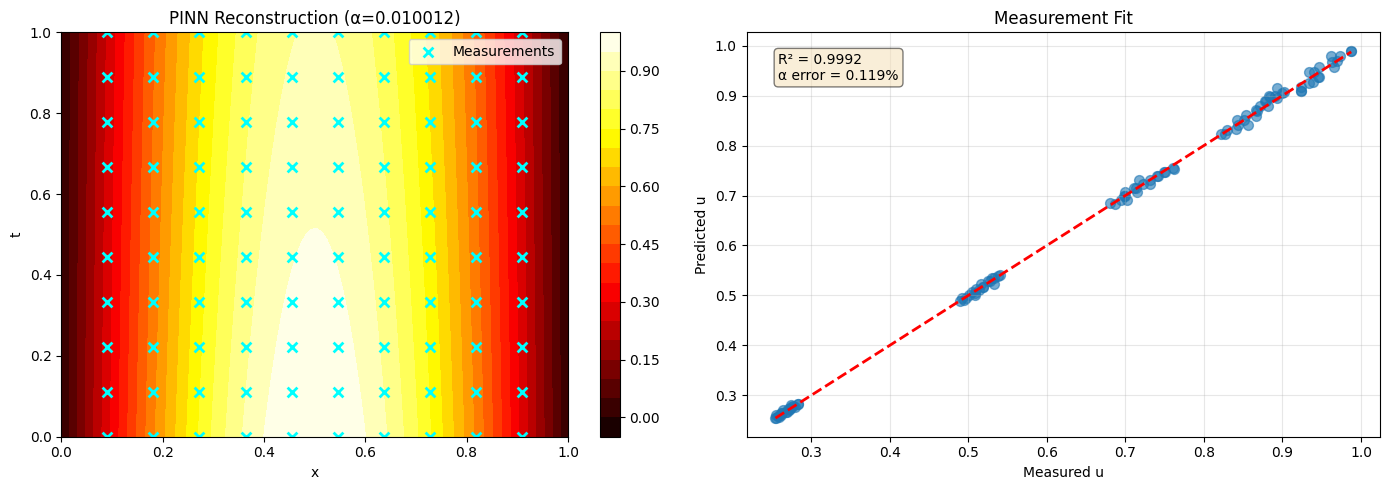

In [16]:
plot_solution(model_inverse, data, alpha_true=0.01, save_path='../results/inverse_5k_aw_lbgfs_reconstruct.png')

**Conclusion**: the adaptive weights helped for the inverse problem!

## Step 4: Experiment with Various Settings

### Effect of noise level


Noise level: 0.1%
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 0.1% (SNR ≈ 60 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 60.3 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1

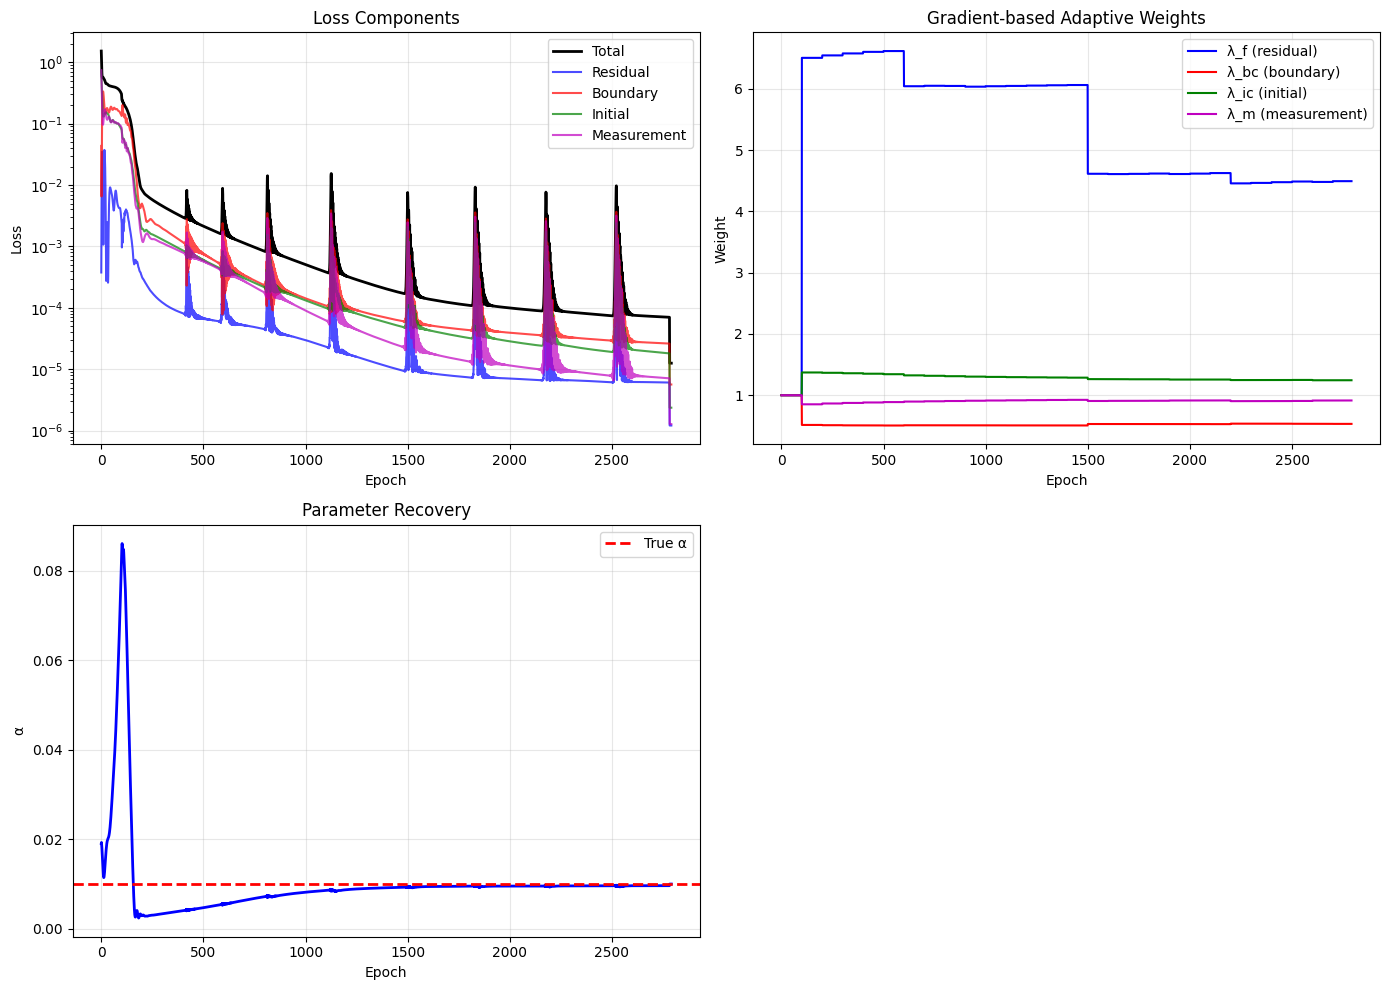


Training complete. Total time: 155.9s

Noise level: 1.0%
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 40.3 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse



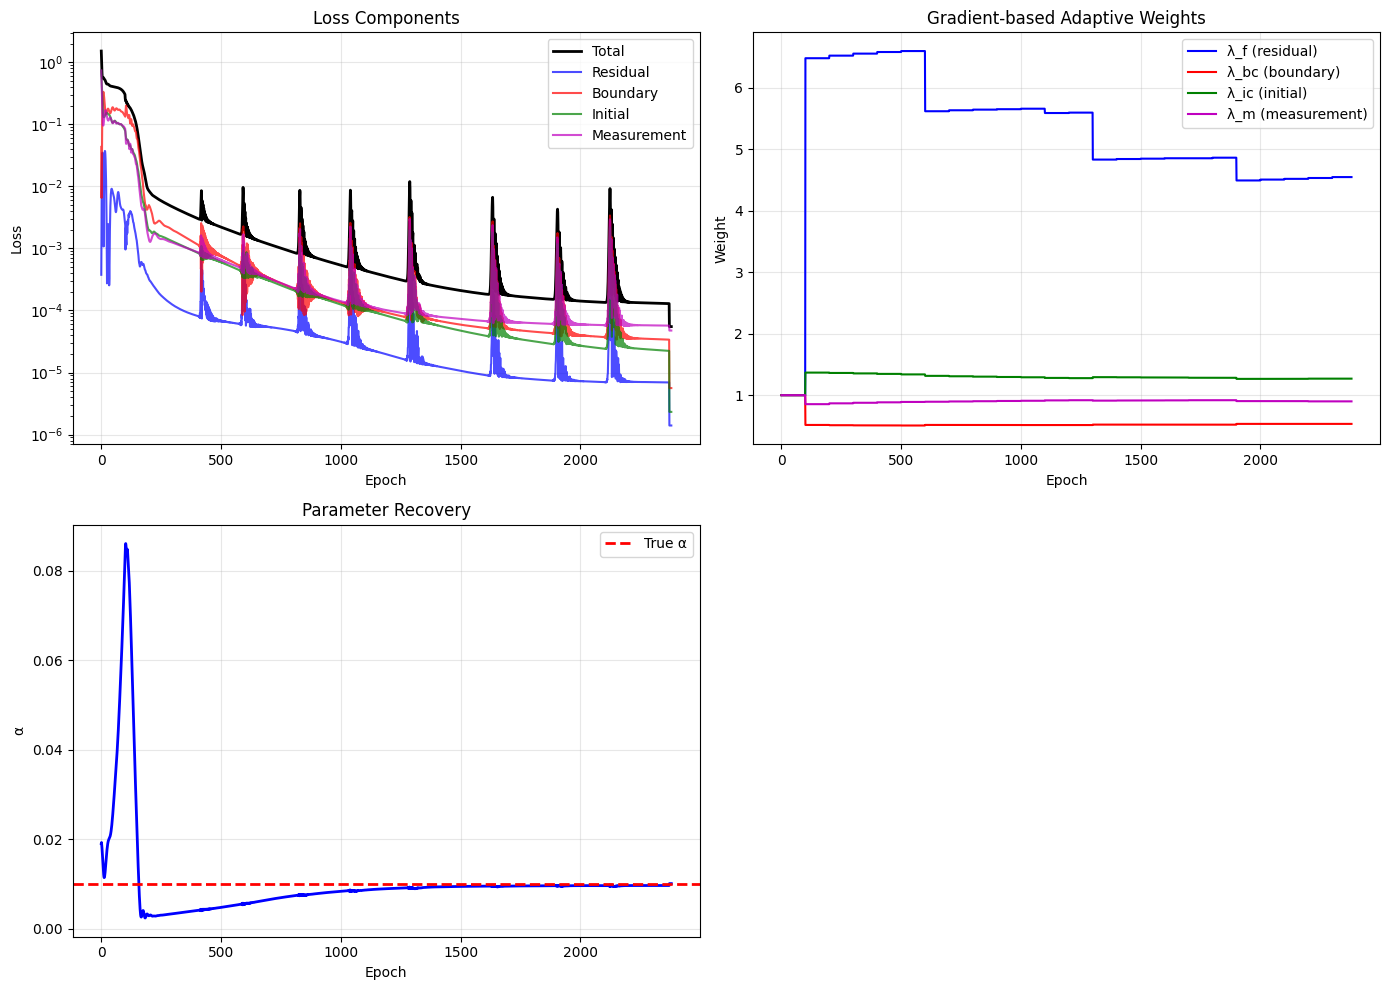


Training complete. Total time: 145.2s

Noise level: 5.0%
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 5.0% (SNR ≈ 26 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 26.3 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse



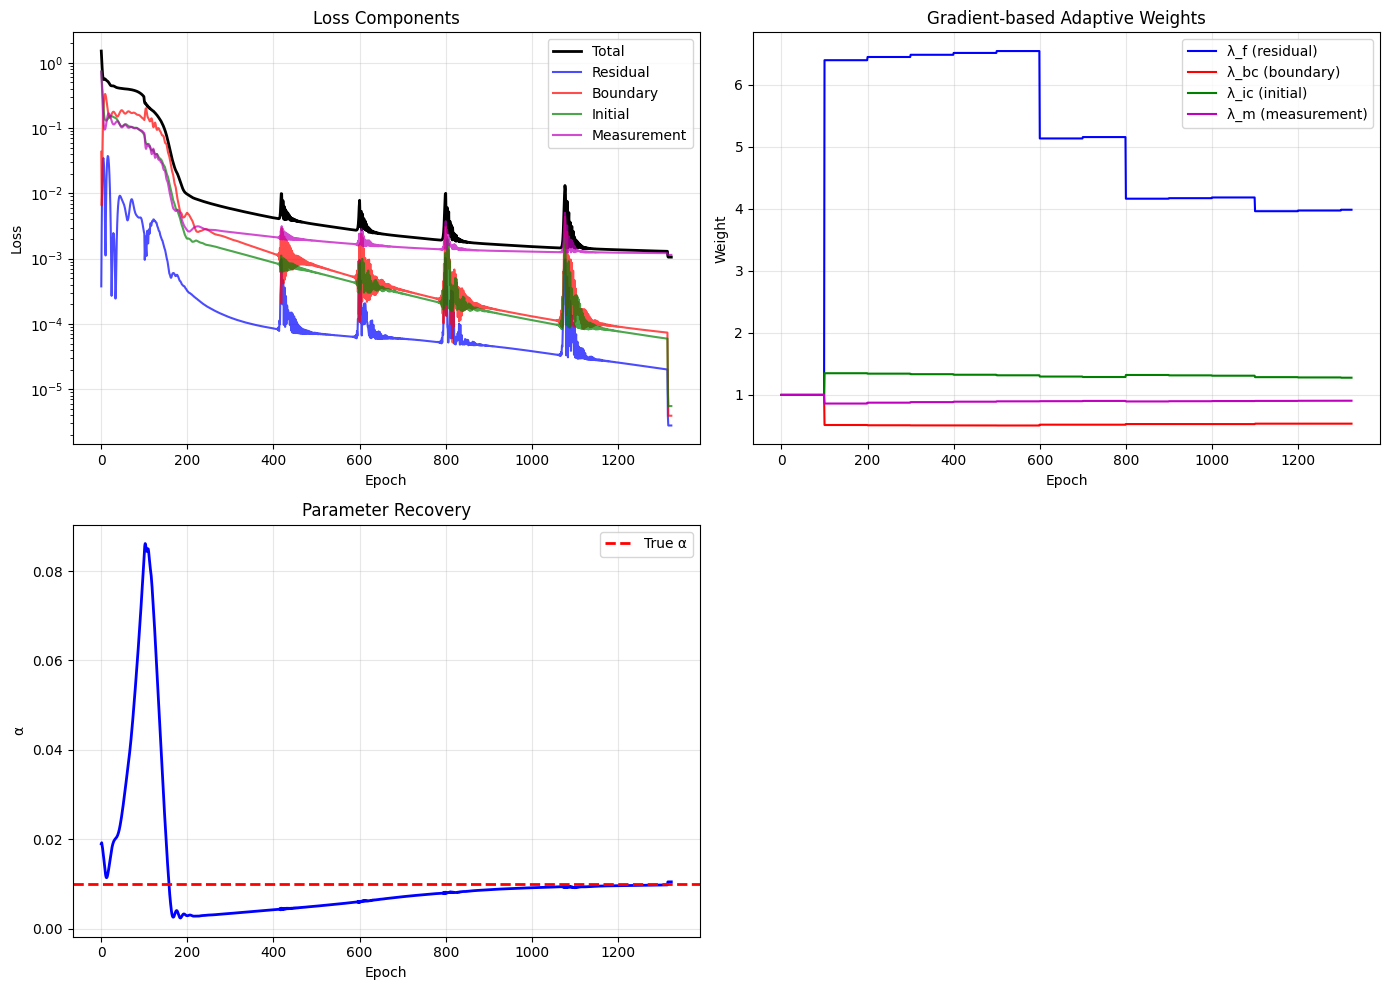


Training complete. Total time: 87.9s

Noise level: 10.0%
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 10.0% (SNR ≈ 20 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 20.3 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse


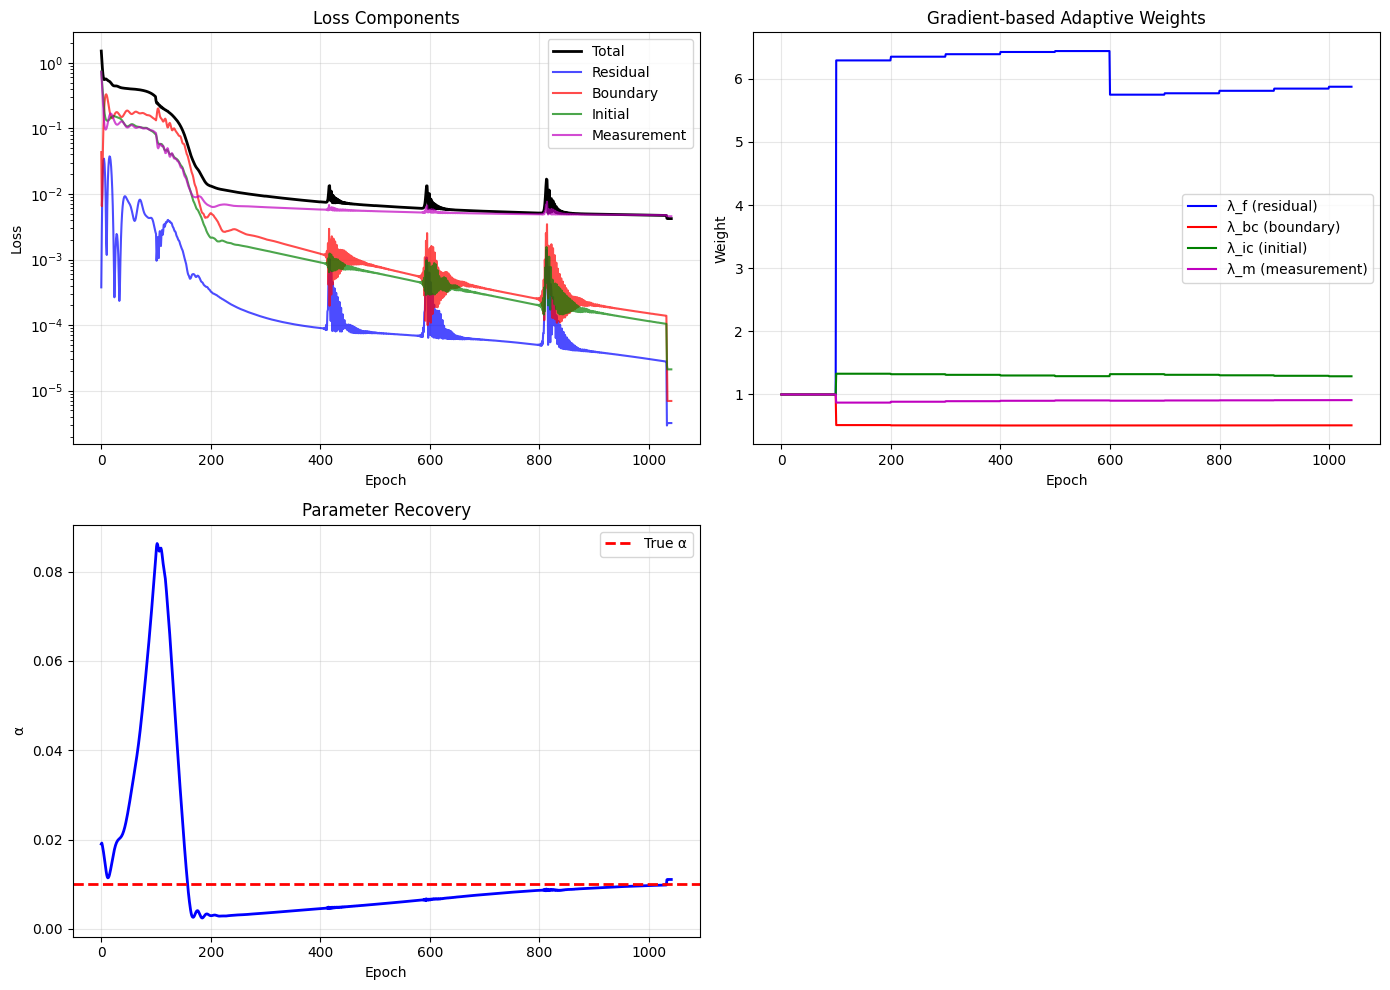


Training complete. Total time: 83.2s


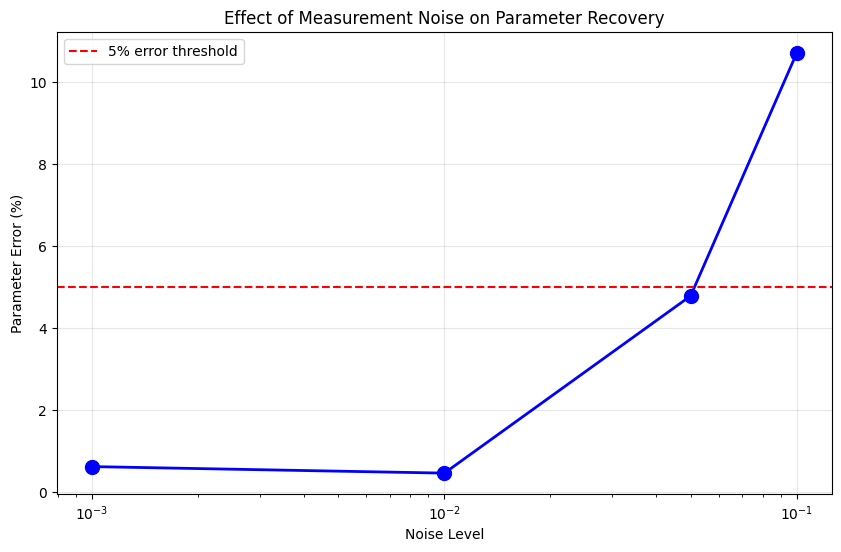

In [17]:
noise_levels = [0.001, 0.01, 0.05, 0.1]  # 0.1%, 1%, 5%, 10%
results = []

for noise in noise_levels:
    print(f"\nNoise level: {noise:.1%}")
    
    # Generate new data with different noise levels
    data_gen_temp = HeatEquationData(
        N_f=10000, 
        N_bc=100,
        N_ic=200,
        N_sensors=10, 
        N_time_measurements=10,
        noise_level=noise, 
        device='cpu'
    )
    data_temp = data_gen_temp.generate_full_dataset()
    
    # Train inverse model for 5000 epochs
    model_temp = HeatPINN(inverse=True, alpha_init=0.02)
    trainer_temp = PINNTrainer(model_temp, data_temp, switch_var=0.1, switch_slope=0.001, adaptive_weights=True)
    trainer_temp.train(epochs=5000, print_every=2500, plot_every=5000)
    
    # Record results
    alpha_recovered = model_temp.get_alpha()
    error = abs(alpha_recovered - 0.01) / 0.01 * 100
    results.append({
        'noise': noise,
        'alpha': alpha_recovered,
        'error': error
    })

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
noises = [r['noise'] for r in results]
errors = [r['error'] for r in results]

ax.plot(noises, errors, 'bo-', markersize=10, linewidth=2)
ax.axhline(y=5, color='r', linestyle='--', label='5% error threshold')
ax.set_xlabel('Noise Level')
ax.set_ylabel('Parameter Error (%)')
ax.set_title('Effect of Measurement Noise on Parameter Recovery')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

### Uncertainty Quantification

Use different RNG seeds to train models and study the variation in predicting $\alpha$

Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.986863e+00
  Residual: 5.275653e-03 (λ=1.00)
  Boundary: 1.129718e-01 (λ=1.00)
  Initial: 9.041088e-01 (λ=1.00)
  Measurement: 9.645065e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Epoch 2500/5000 (130.0s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.658185e-04
  Residual: 1.251871e-05 (λ=3.55)
  Boundary: 4.542586e-05 (λ=0.53)
  Initial: 2.870025e-05 (λ=1.23)
  Measurement: 6.272014e-05 (λ=0.99)
  Alpha: 0.009738 (true: 0.01)

Switching to L-BFGS at epoch 2663
  Variance ratio: 0.099884 < 0.1
  Slope (log): |-0.000586| < 0.001

Final training plot:


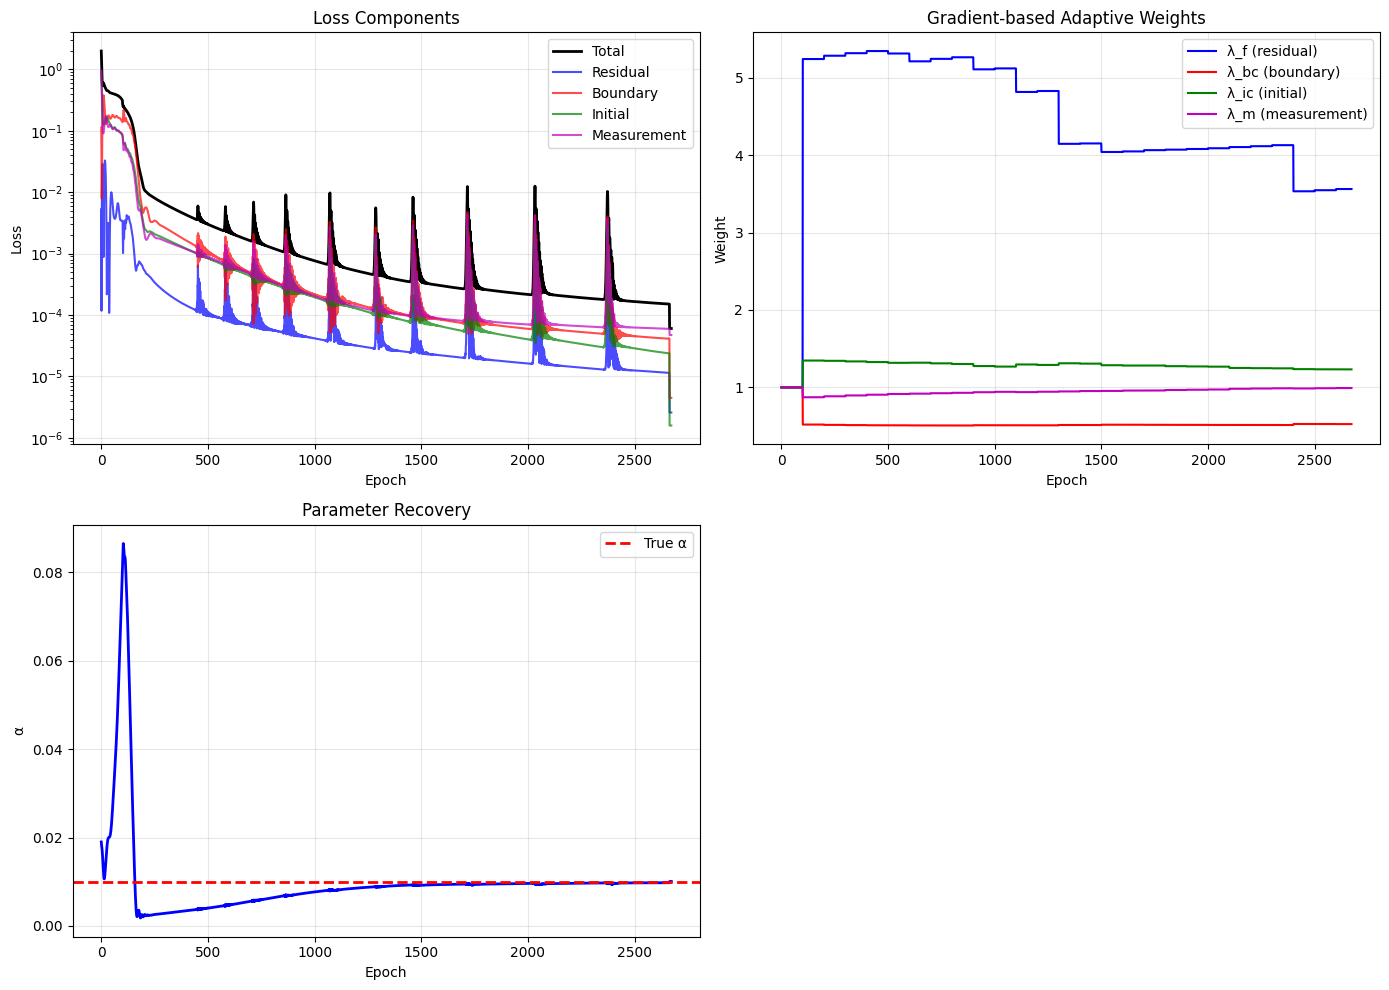


Training complete. Total time: 145.0s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.0s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.126033e+00
  Residual: 6.696954e-03 (λ=1.00)
  Boundary: 4.462265e-03 (λ=1.00)
  Initial: 5.330613e-01 (λ=1.00)
  Measurement: 5.818123e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Epoch 2500/5000 (131.0s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.318570e-04
  Residual: 5.403132e-05 (λ=1.17)
  Boundary: 1.176703e-05 (λ=0.66)
  Initial: 7.033998e-06 (λ=1.71)
  Measurement: 5.129219e-05 (λ=0.95)
  Alpha: 0.009647 (true: 0.01)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 2926
  Variance ratio: 0.096820 < 0.1
  Slope (log): |-0.000534| < 0.001

F

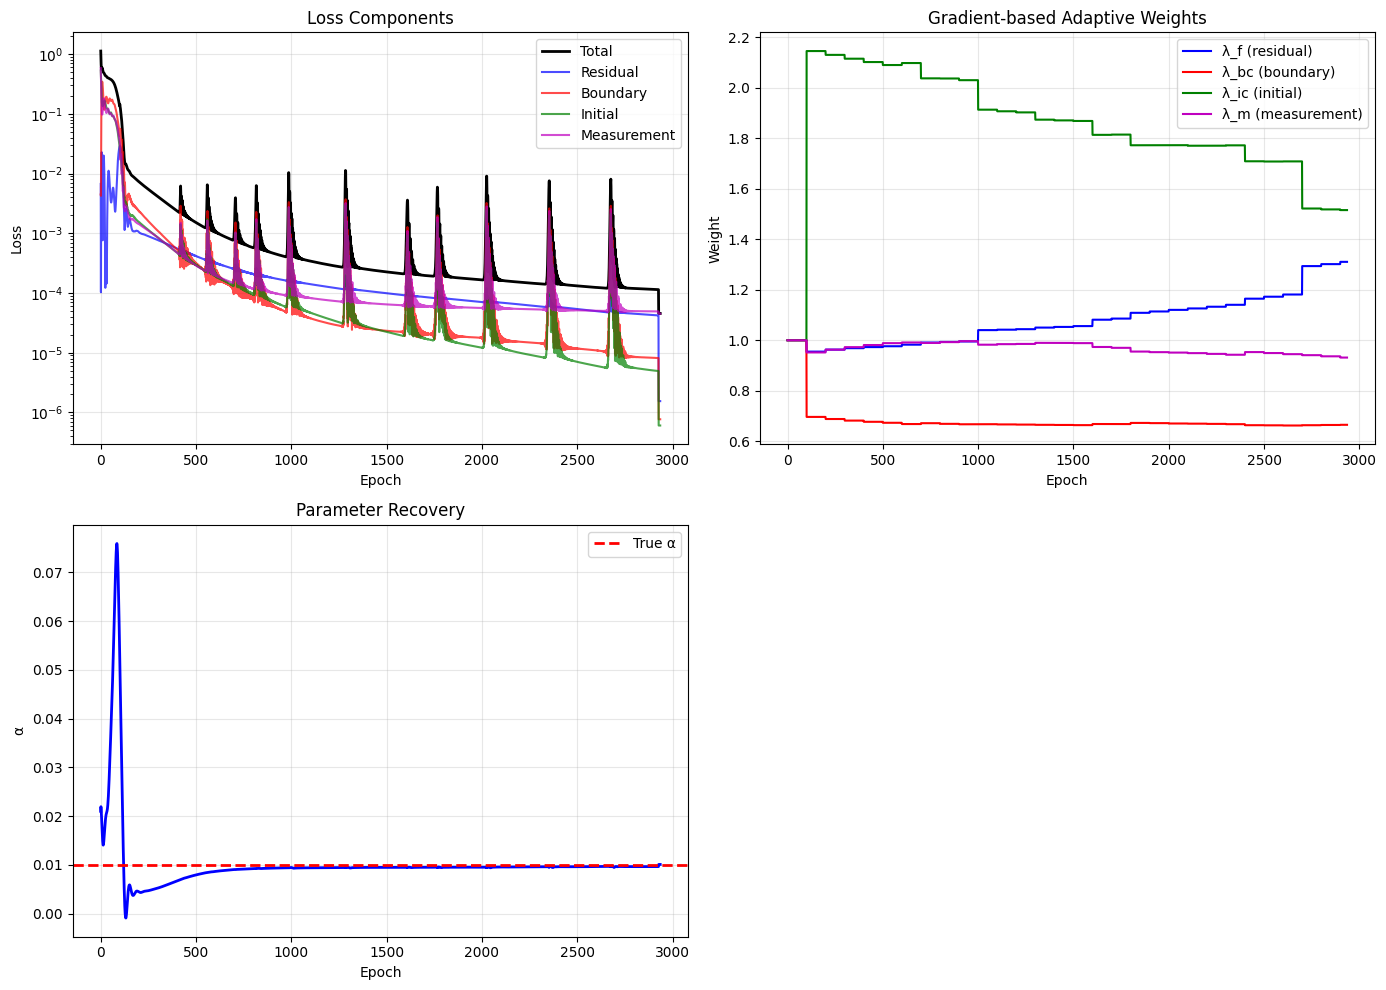


Training complete. Total time: 159.9s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.0s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.156174e+00
  Residual: 1.793606e-02 (λ=1.00)
  Boundary: 6.986184e-03 (λ=1.00)
  Initial: 5.212489e-01 (λ=1.00)
  Measurement: 6.100031e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Epoch 2500/5000 (133.9s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.523383e-04
  Residual: 1.474738e-05 (λ=2.77)
  Boundary: 3.694364e-05 (λ=0.59)
  Initial: 2.642766e-05 (λ=1.45)
  Measurement: 6.459634e-05 (λ=0.80)
  Alpha: 0.009414 (true: 0.01)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 3697
  Variance ratio: 0.092028 < 0.1
  Slope (log): |-0.000517| < 0.001

F

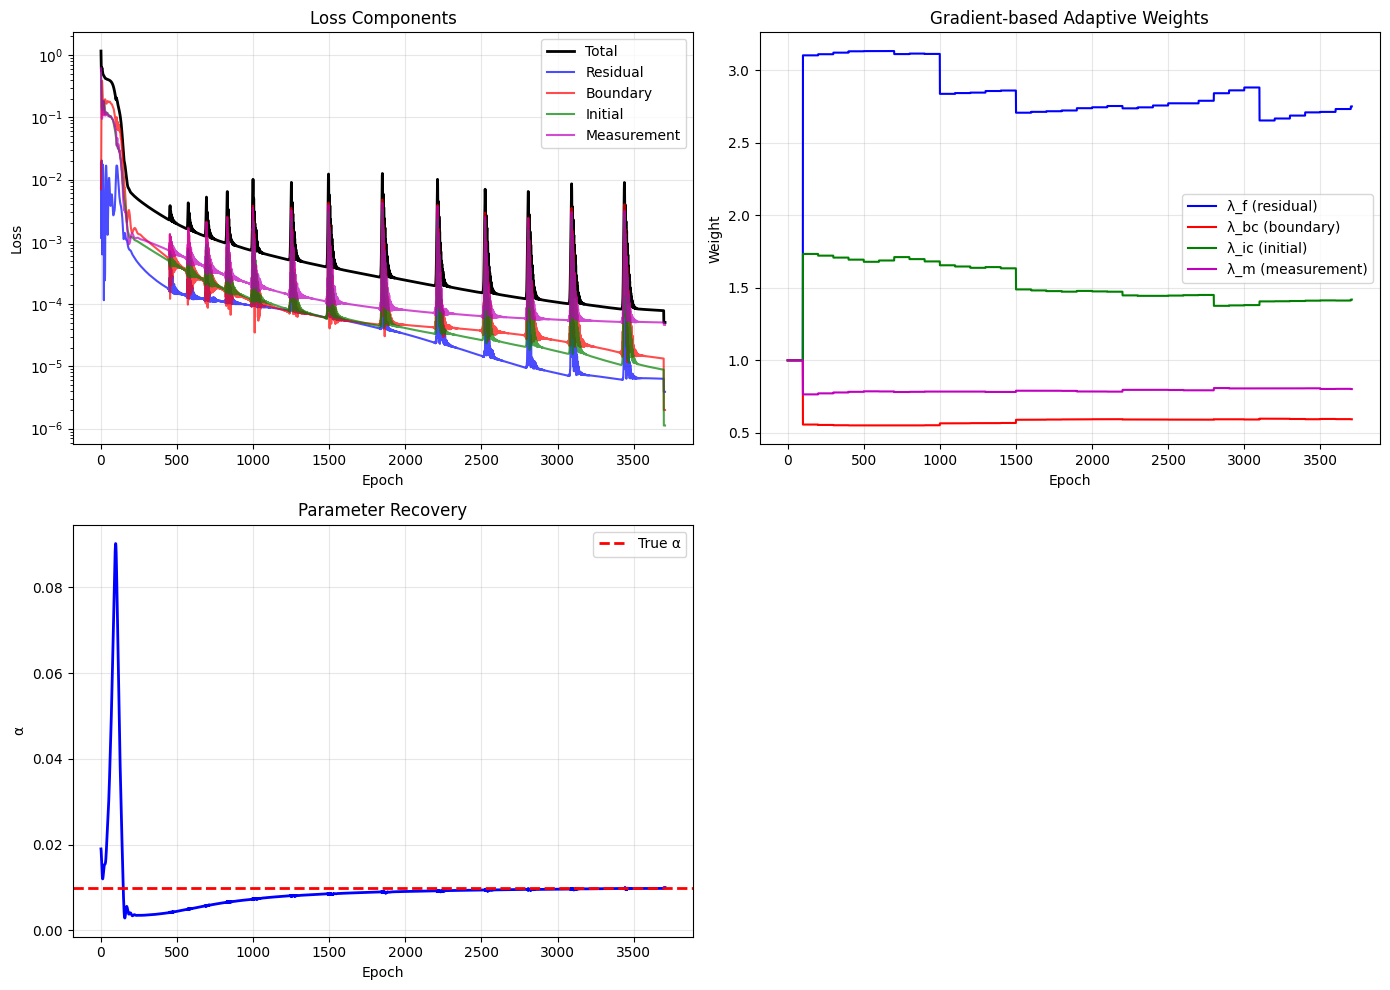


Training complete. Total time: 203.9s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.016659e+00
  Residual: 2.238766e-01 (λ=1.00)
  Boundary: 8.306137e-02 (λ=1.00)
  Initial: 4.720625e-01 (λ=1.00)
  Measurement: 2.376590e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Switching to L-BFGS at epoch 1664
  Variance ratio: 0.097873 < 0.1
  Slope (log): |-0.000551| < 0.001

Final training plot:


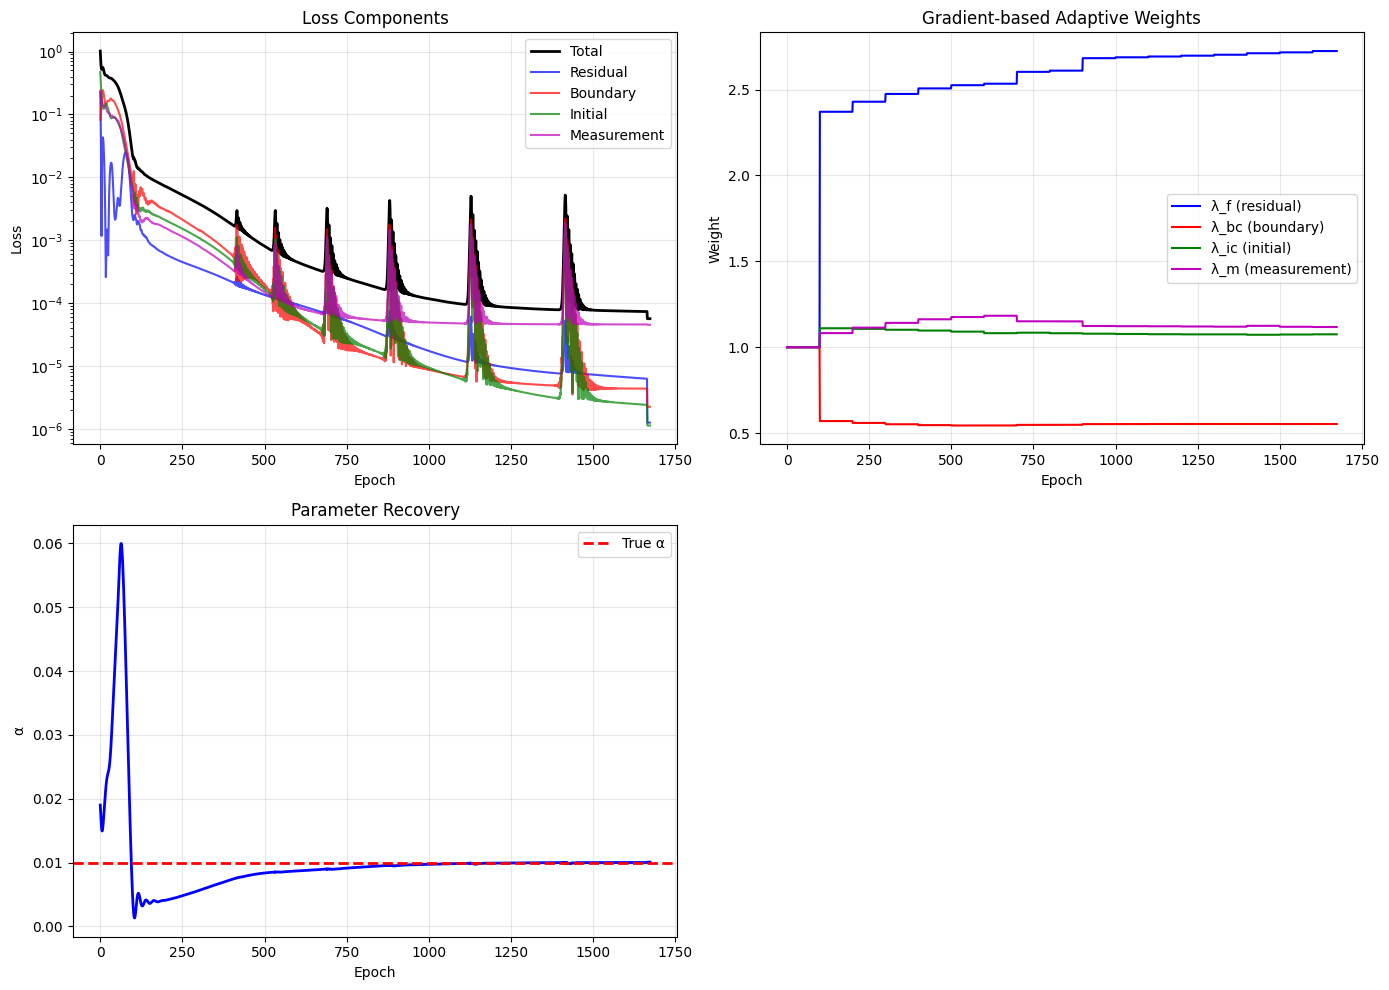


Training complete. Total time: 97.4s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.338553e+00
  Residual: 3.597515e-04 (λ=1.00)
  Boundary: 1.917126e-02 (λ=1.00)
  Initial: 6.651743e-01 (λ=1.00)
  Measurement: 6.538478e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Epoch 2500/5000 (134.9s)
  Adam learning rate: 1.00e-03
  Total Loss: 8.921216e-05
  Residual: 8.606034e-06 (λ=2.56)
  Boundary: 1.772070e-05 (λ=0.51)
  Initial: 6.141727e-06 (λ=1.47)
  Measurement: 4.826068e-05 (λ=1.02)
  Alpha: 0.009782 (true: 0.01)

Switching to L-BFGS at epoch 2524
  Variance ratio: 0.099852 < 0.1
  Slope (log): |-0.000585| < 0.001

Final training plot:


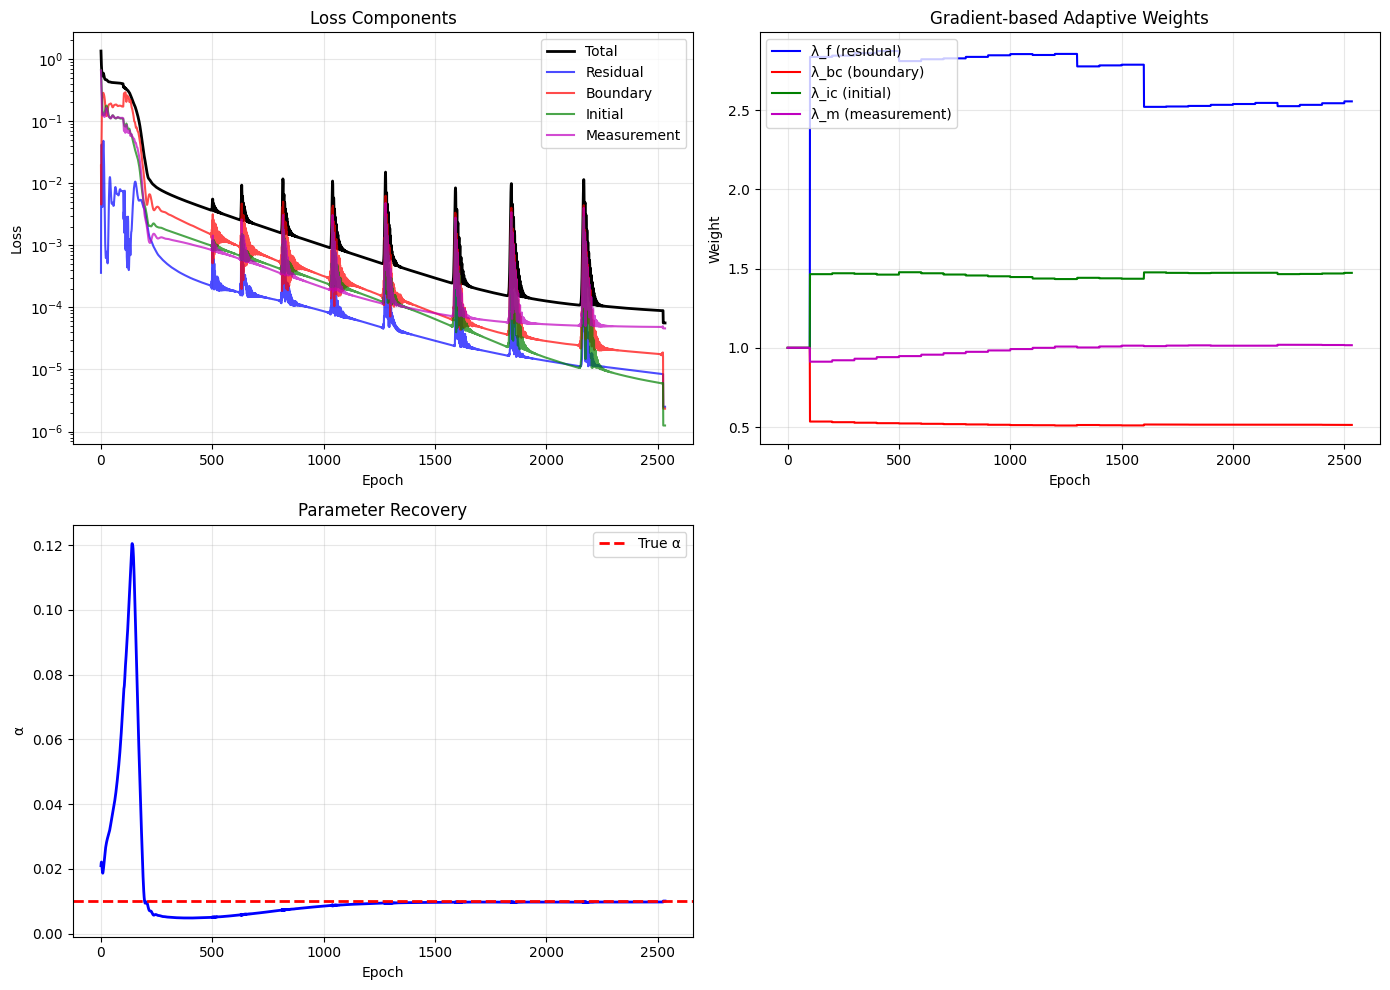


Training complete. Total time: 143.9s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.267476e+00
  Residual: 1.647010e-02 (λ=1.00)
  Boundary: 1.492682e-02 (λ=1.00)
  Initial: 5.742816e-01 (λ=1.00)
  Measurement: 6.617976e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Epoch 2500/5000 (135.2s)
  Adam learning rate: 5.00e-04
  Total Loss: 2.146951e-04
  Residual: 3.636853e-05 (λ=1.60)
  Boundary: 3.795531e-05 (λ=0.58)
  Initial: 3.847019e-05 (λ=1.56)
  Measurement: 7.451510e-05 (λ=1.00)
  Alpha: 0.009571 (true: 0.01)

Switching to L-BFGS at epoch 2596
  Variance ratio: 0.094056 < 0.1
  Slope (log): |-0.000517| < 0.001

F

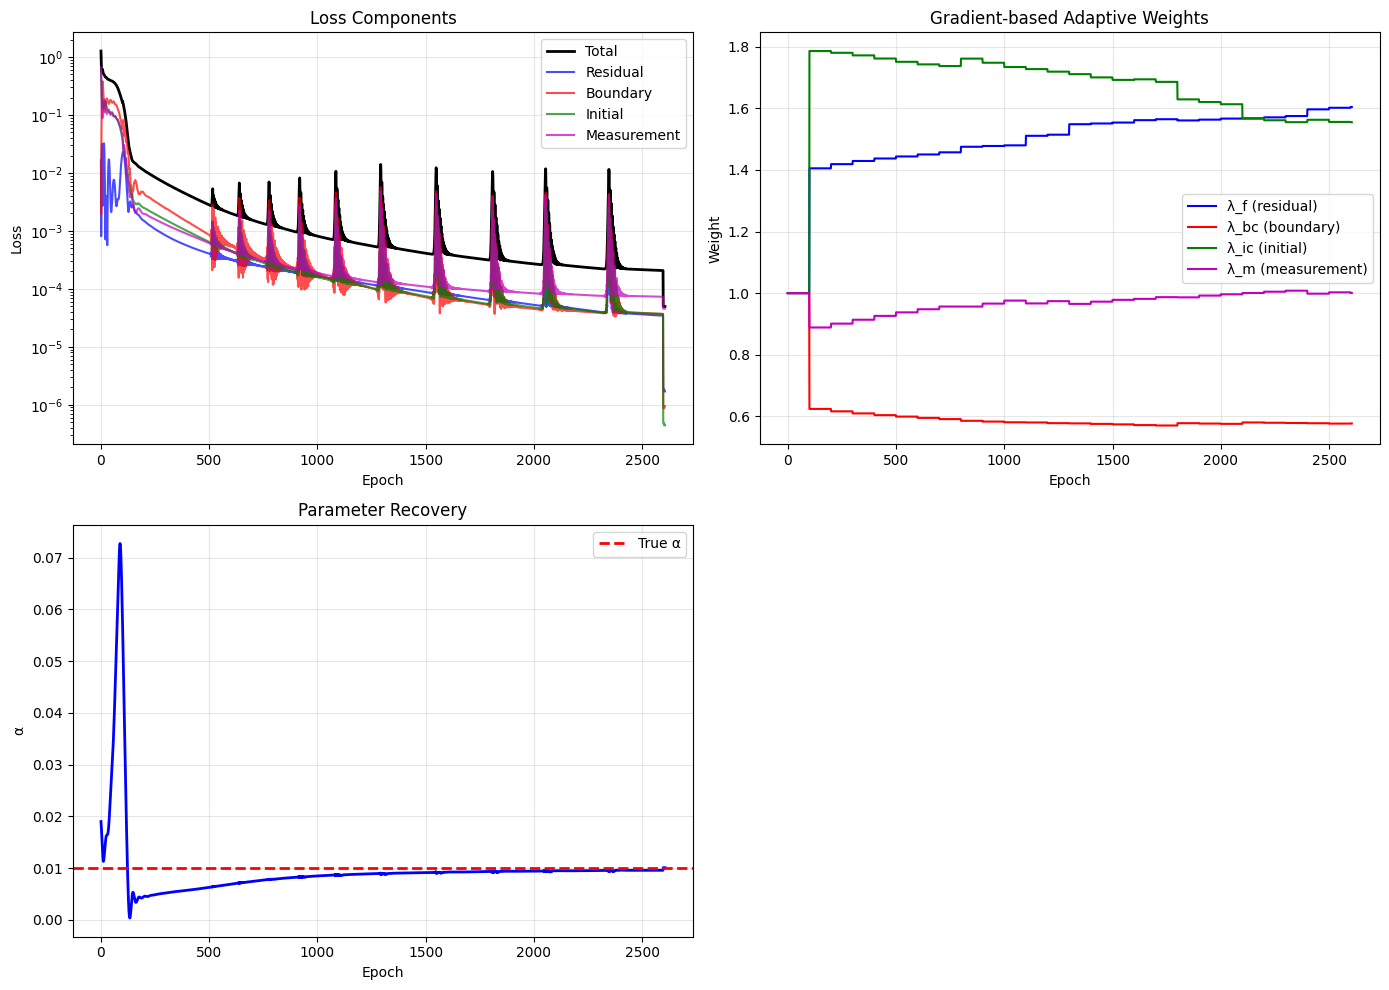


Training complete. Total time: 153.7s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 9.418670e-01
  Residual: 4.503932e-02 (λ=1.00)
  Boundary: 1.325617e-02 (λ=1.00)
  Initial: 5.097075e-01 (λ=1.00)
  Measurement: 3.738640e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 2141
  Variance ratio: 0.098540 < 0.1
  Slope (log): |-0.000554| < 0.001

Final training plot:


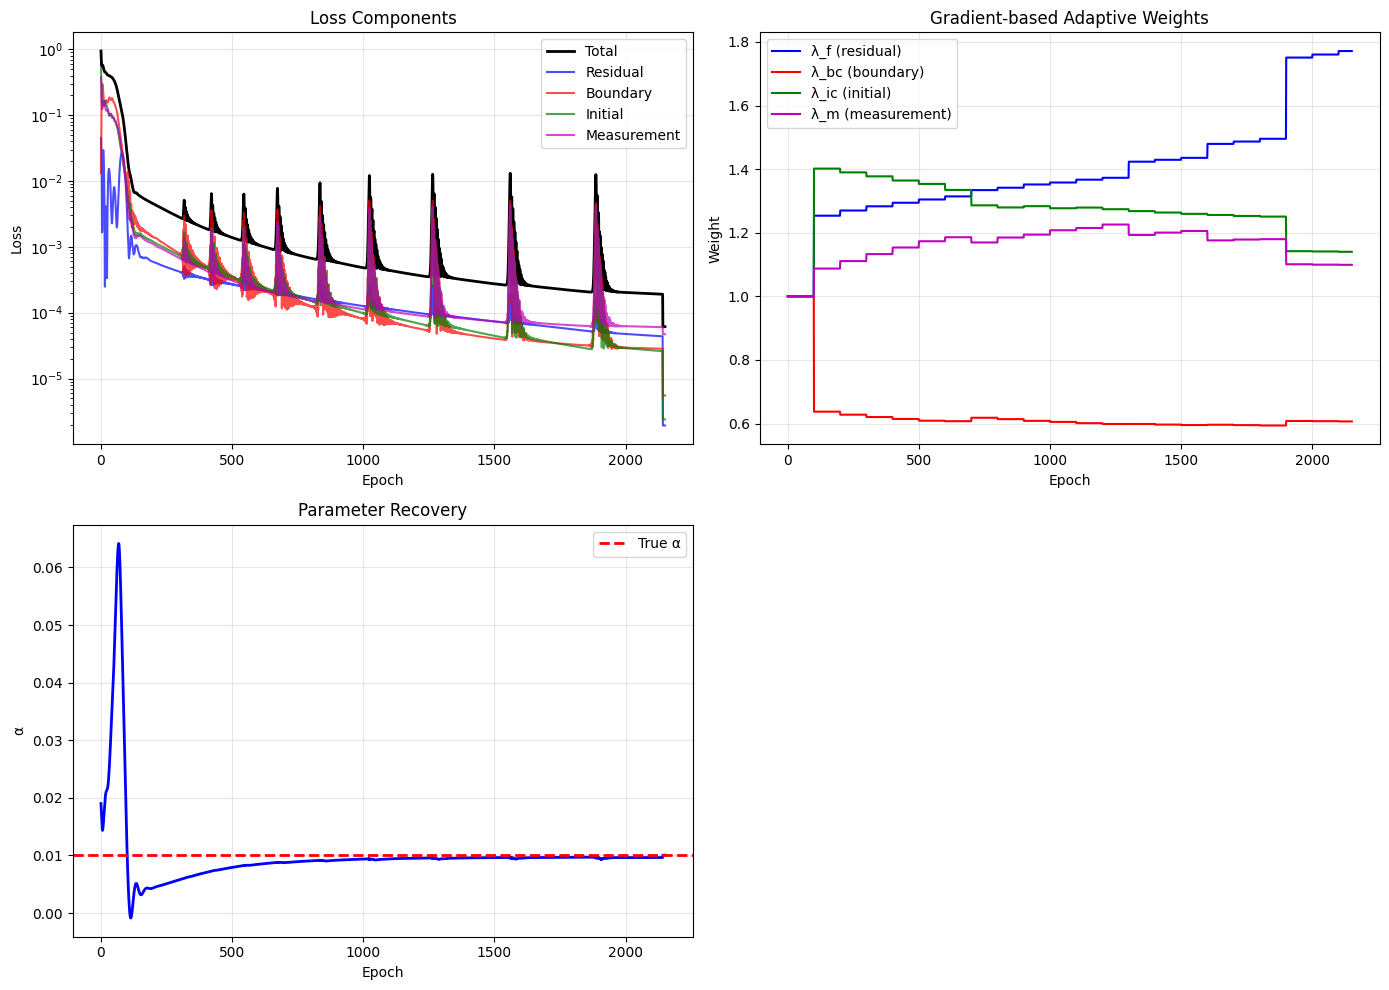


Training complete. Total time: 123.7s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.138059e+00
  Residual: 9.023647e-02 (λ=1.00)
  Boundary: 1.778947e-02 (λ=1.00)
  Initial: 4.168714e-01 (λ=1.00)
  Measurement: 6.131615e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 1953
  Variance ratio: 0.097123 < 0.1
  Slope (log): |-0.000556| < 0.001

Final training plot:


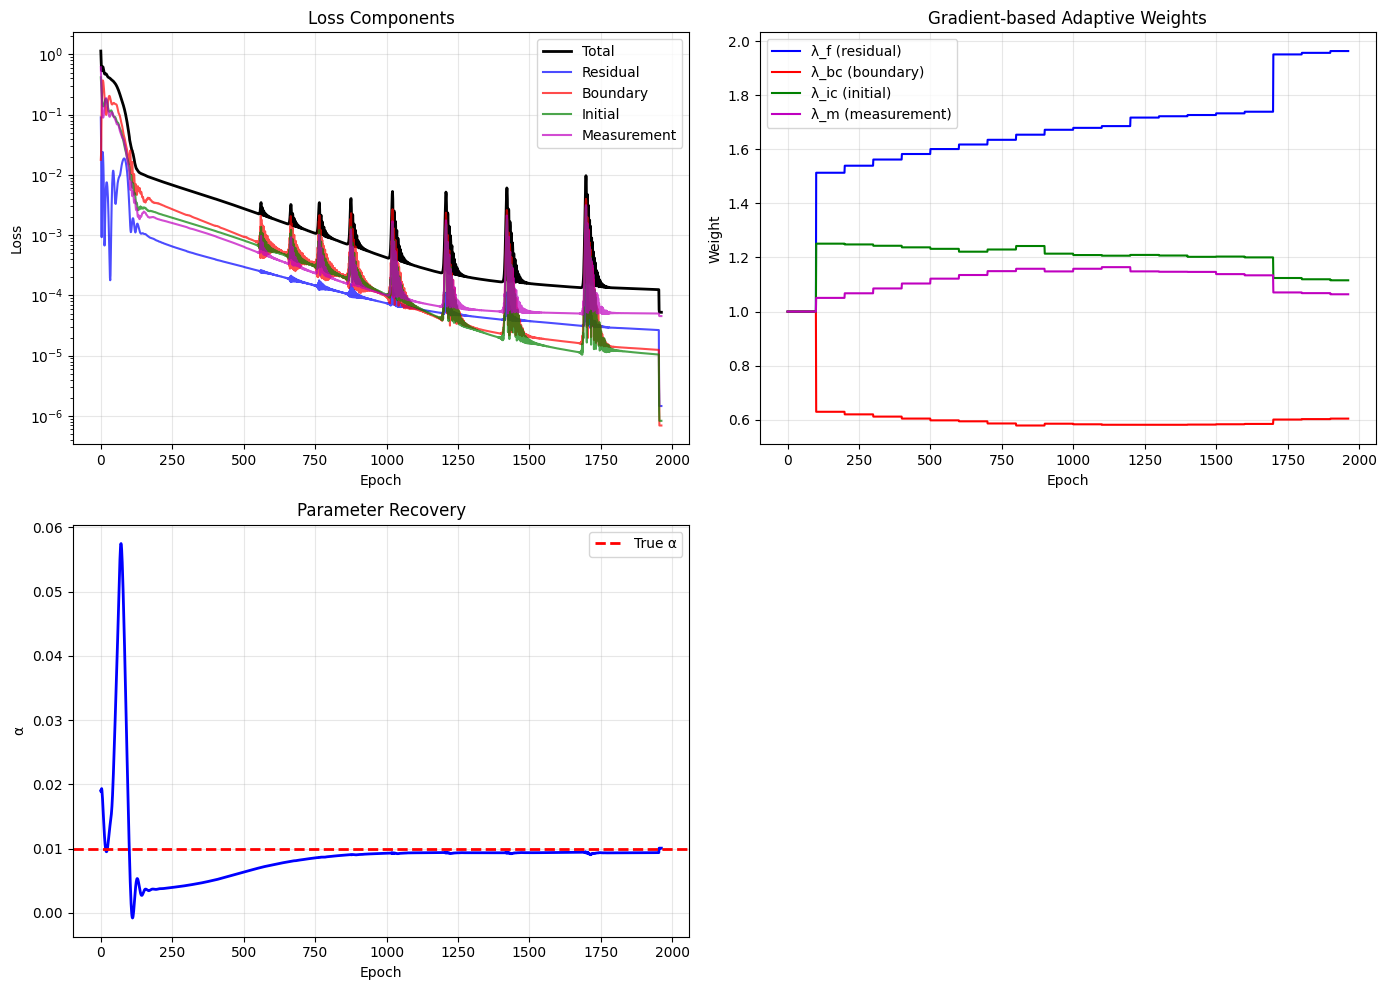


Training complete. Total time: 112.6s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.272557e+00
  Residual: 6.419275e-02 (λ=1.00)
  Boundary: 1.907125e-02 (λ=1.00)
  Initial: 6.893194e-01 (λ=1.00)
  Measurement: 4.999742e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Epoch 2500/5000 (134.9s)
  Adam learning rate: 1.00e-03
  Total Loss: 8.102598e-05
  Residual: 1.389564e-05 (λ=1.53)
  Boundary: 1.283081e-05 (λ=0.59)
  Initial: 5.014788e-06 (λ=2.05)
  Measurement: 4.894882e-05 (λ=0.86)
  Alpha: 0.009802 (true: 0.01)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 2833
  Variance ratio: 0.093606 < 0.1
  Slope (log): |-0.000458| < 0.001

F

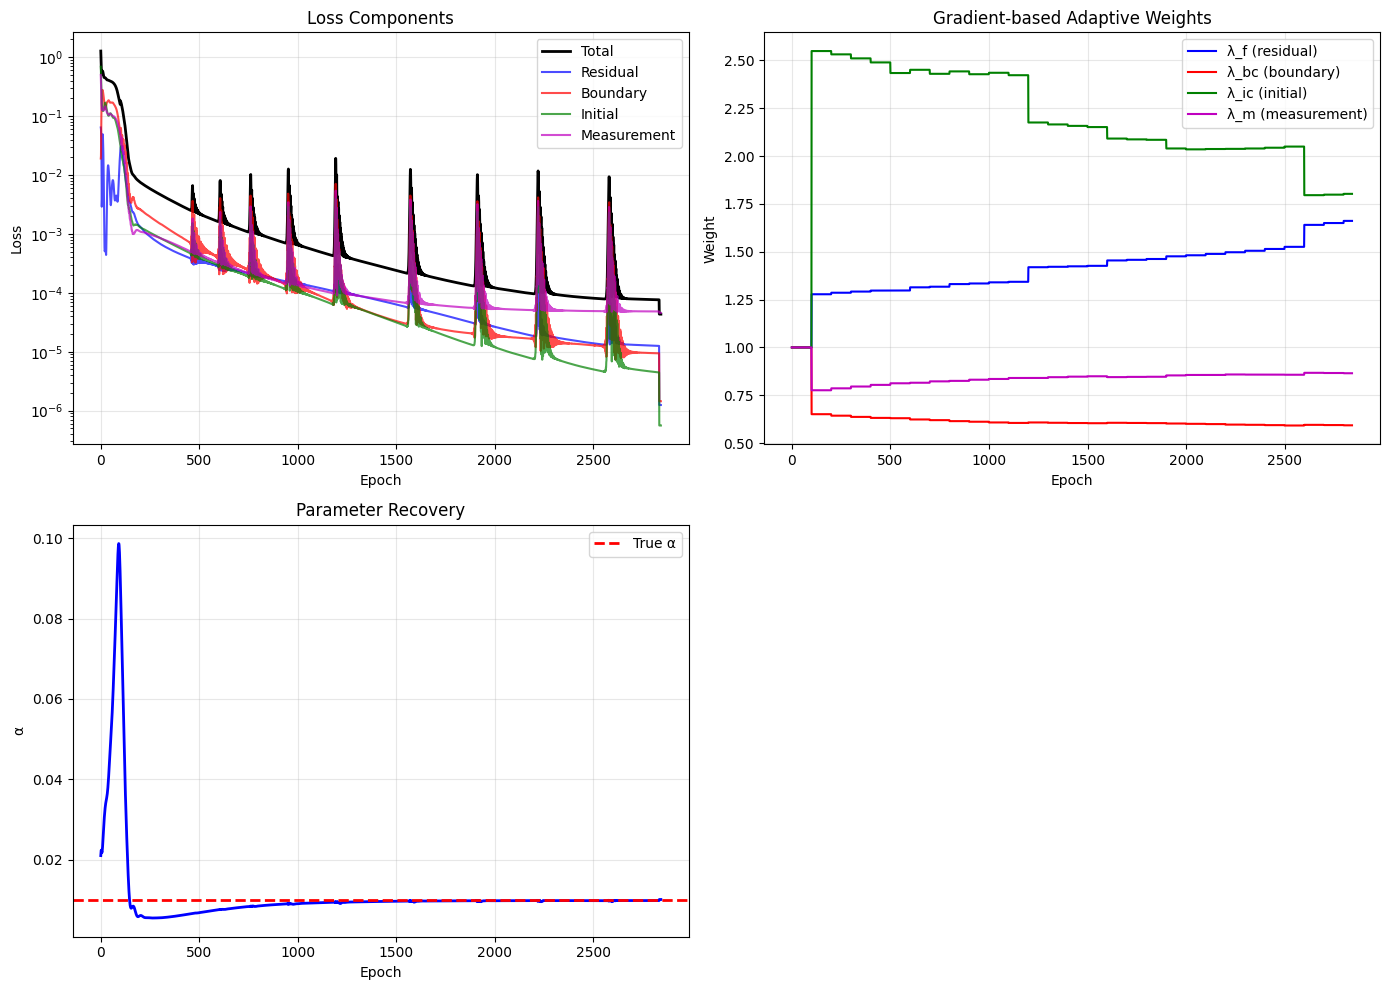


Training complete. Total time: 162.5s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.094697e+00
  Residual: 8.520605e-02 (λ=1.00)
  Boundary: 1.710433e-02 (λ=1.00)
  Initial: 5.902013e-01 (λ=1.00)
  Measurement: 4.021853e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Epoch 2500/5000 (136.7s)
  Adam learning rate: 1.00e-03
  Total Loss: 2.121173e-04
  Residual: 4.637174e-05 (λ=1.29)
  Boundary: 2.990552e-05 (λ=0.71)
  Initial: 3.759140e-05 (λ=1.41)
  Measurement: 8.622652e-05 (λ=0.91)
  Alpha: 0.009453 (true: 0.01)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at epoch 2727
  Variance ratio: 0.094050 < 0.1
  Slope (log): |-0.000553| < 0.001

F

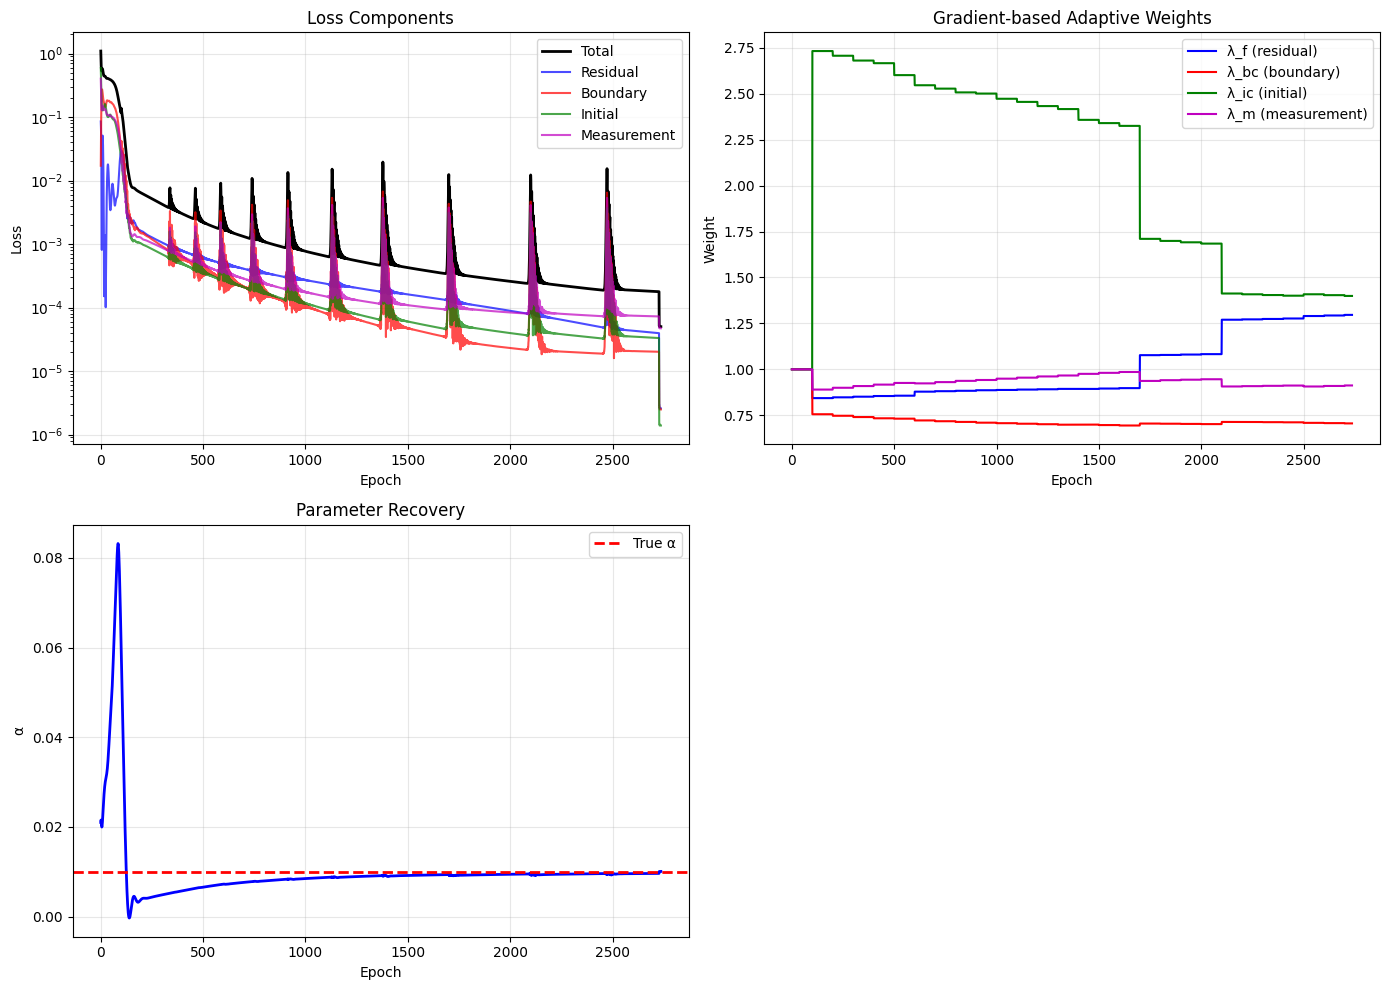


Training complete. Total time: 158.6s

Mean ± std: α = 0.010068 ± 0.000029


In [19]:
# Train ensemble
results = []
for seed in range(10):
    torch.manual_seed(seed)
    model = HeatPINN(inverse=True, alpha_init=0.02)
    trainer = PINNTrainer(model, data, switch_var=0.1, switch_slope=0.001, adaptive_weights=True)
    trainer.train(epochs=5000, print_every=2500, plot_every=5000)
    results.append(model.get_alpha())

alpha_mean = np.mean(results)
alpha_std = np.std(results)
print("\n" + "=" * 50)
print(f"Mean ± std: α = {alpha_mean:.6f} ± {alpha_std:.6f}")
print("=" * 50)

### Sensitivity to initial guess

Vary the starting guess for $\alpha$ and study its impact on parameter recovery


Starting alpha: 0.0050
Inverse problem mode: alpha initialized to 0.005
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.098578e+00
  Residual: 2.065267e-02 (λ=1.00)
  Boundary: 5.271954e-03 (λ=1.00)
  Initial: 4.957191e-01 (λ=1.00)
  Measurement: 5.769343e-01 (λ=1.00)
  Alpha: 0.004000 (true: 0.01)

Switching to L-BFGS at epoch 1371
  Variance ratio: 0.095965 < 0.1
  Slope (log): |-0.000466| < 0.001

Final training plot:


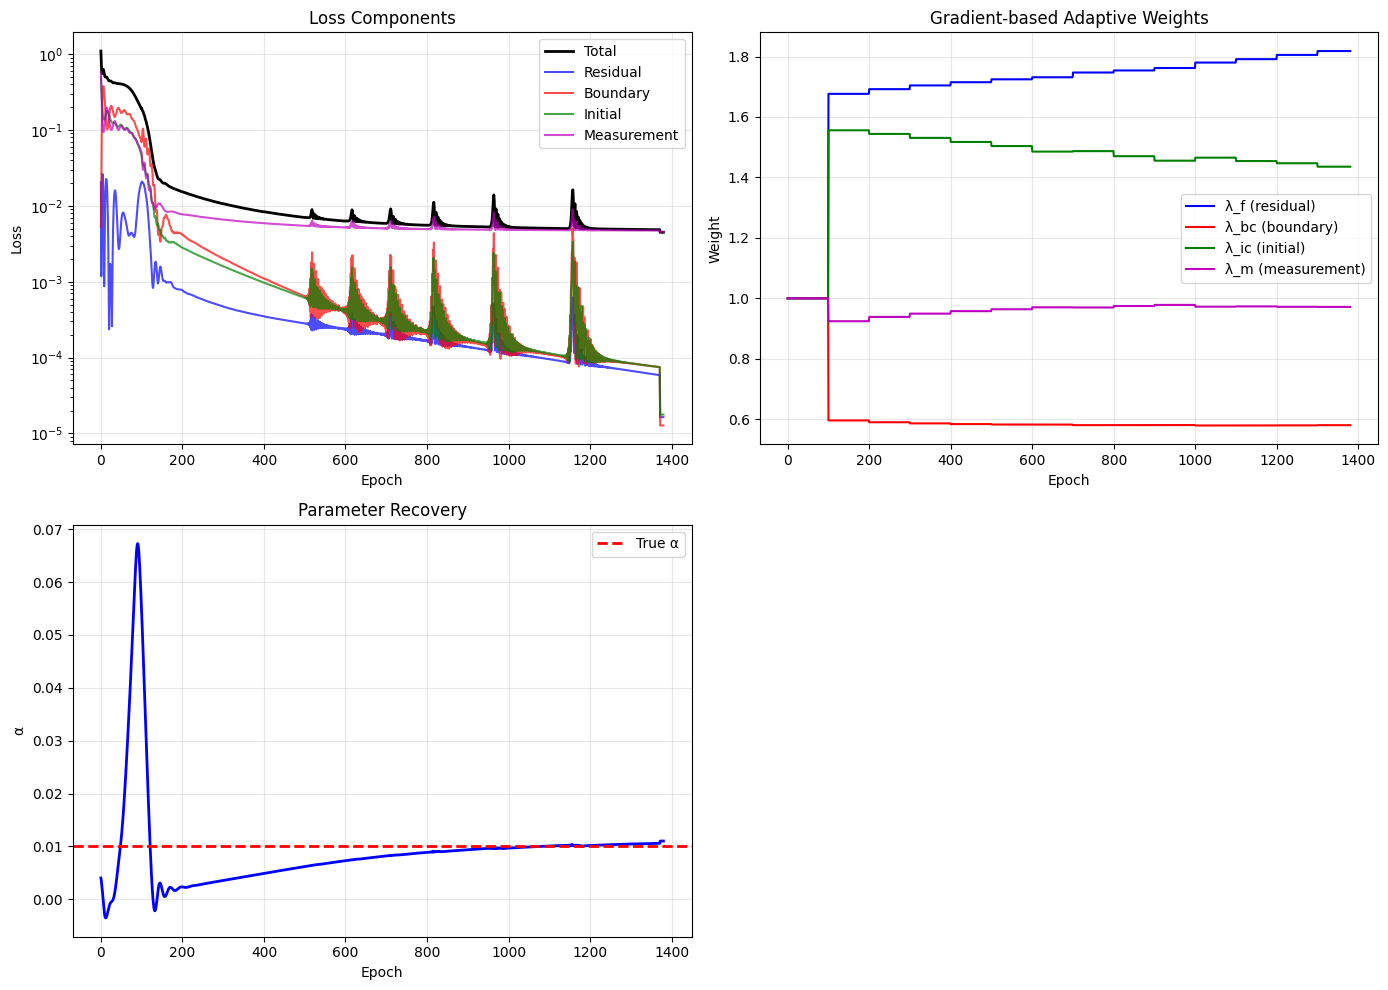


Training complete. Total time: 89.1s

Starting alpha: 0.0500
Inverse problem mode: alpha initialized to 0.05
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 8.600878e-01
  Residual: 9.997380e-04 (λ=1.00)
  Boundary: 5.686364e-03 (λ=1.00)
  Initial: 4.272307e-01 (λ=1.00)
  Measurement: 4.261710e-01 (λ=1.00)
  Alpha: 0.051000 (true: 0.01)

Switching to L-BFGS at epoch 1085
  Variance ratio: 0.093542 < 0.1
  Slope (log): |-0.000543| < 0.001

Final training plot:


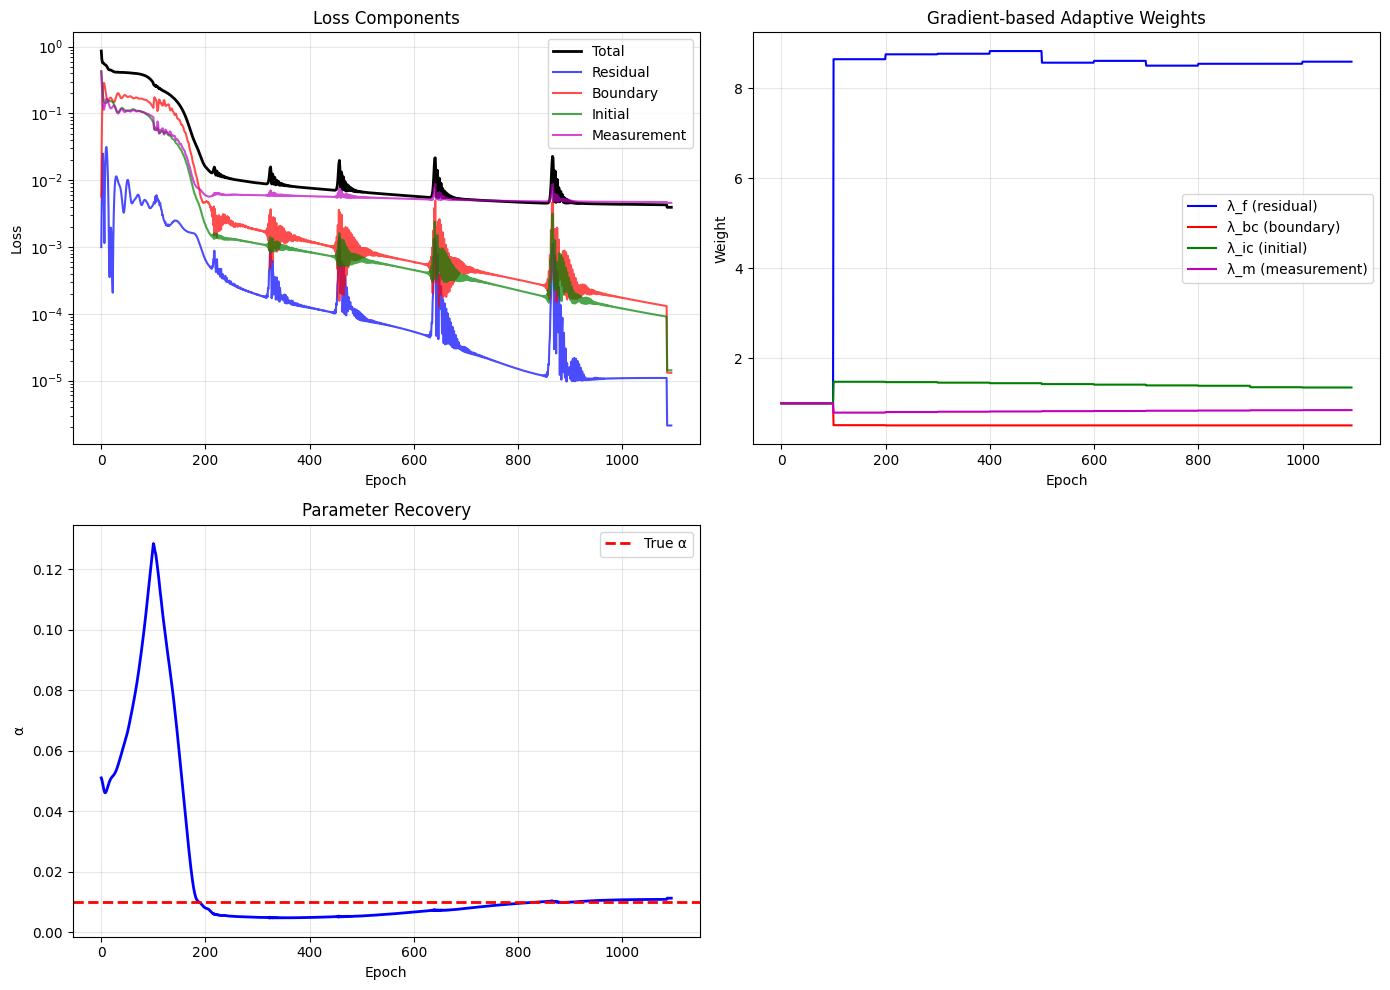


Training complete. Total time: 71.3s

Starting alpha: 0.5000
Inverse problem mode: alpha initialized to 0.5
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 9.974738e-01
  Residual: 1.094364e-03 (λ=1.00)
  Boundary: 5.169261e-04 (λ=1.00)
  Initial: 5.011666e-01 (λ=1.00)
  Measurement: 4.946958e-01 (λ=1.00)
  Alpha: 0.499000 (true: 0.01)

Switching to L-BFGS at epoch 1064
  Variance ratio: 0.099019 < 0.1
  Slope (log): |-0.000590| < 0.001

Final training plot:


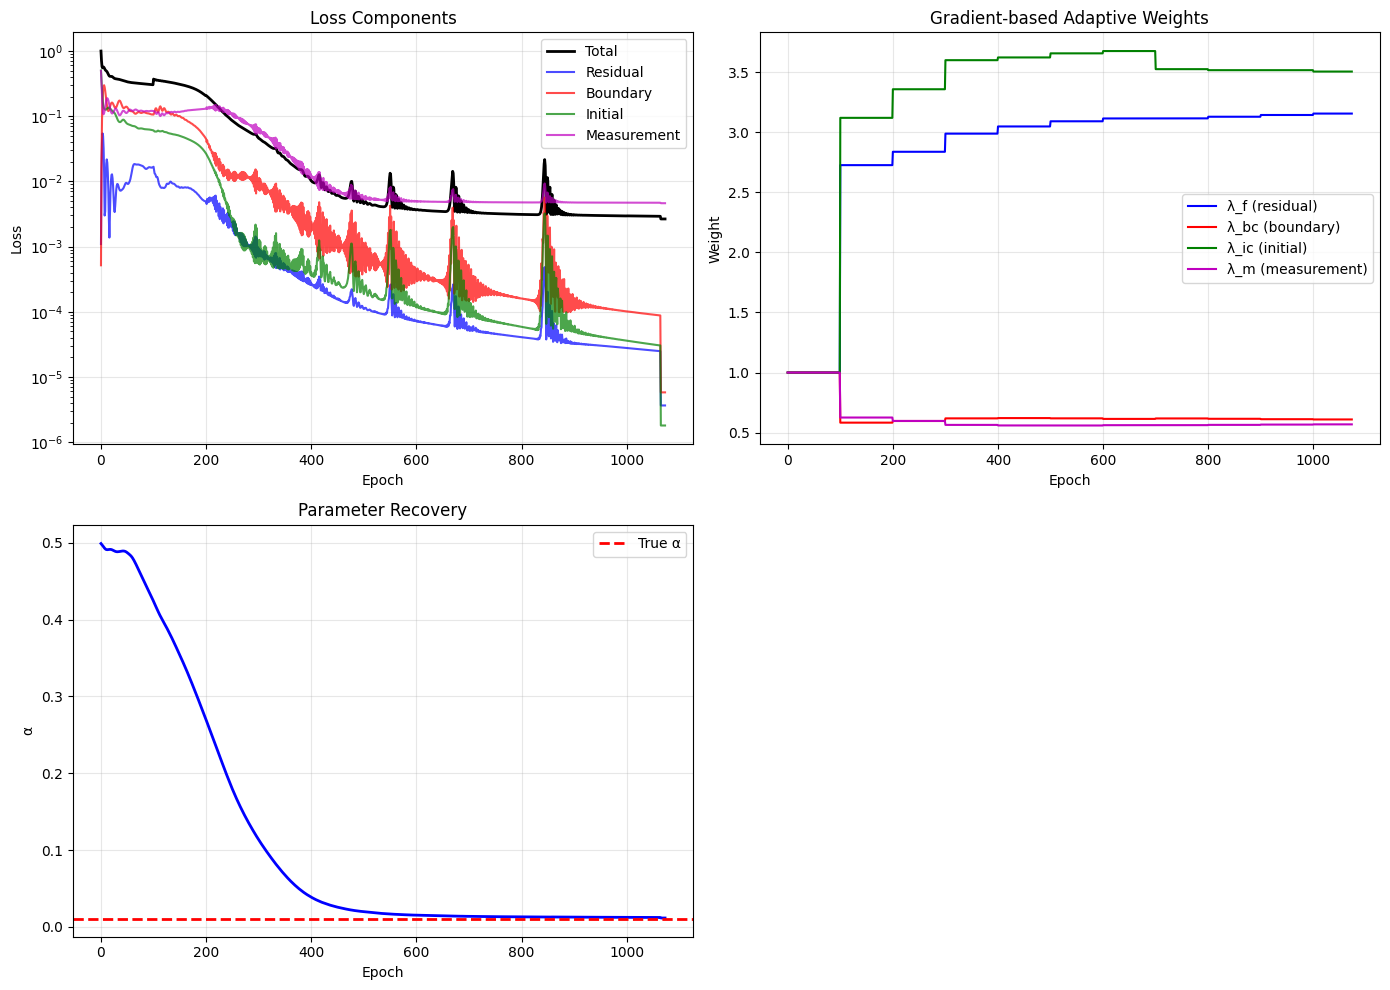


Training complete. Total time: 66.1s

Starting alpha: 5.0000
Inverse problem mode: alpha initialized to 5.0
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.196688e+00
  Residual: 1.091302e-01 (λ=1.00)
  Boundary: 3.212563e-03 (λ=1.00)
  Initial: 5.874637e-01 (λ=1.00)
  Measurement: 4.968813e-01 (λ=1.00)
  Alpha: 4.999000 (true: 0.01)

Switching to L-BFGS at epoch 290
  Variance ratio: 0.070502 < 0.1
  Slope (log): |-0.000149| < 0.001

Final training plot:


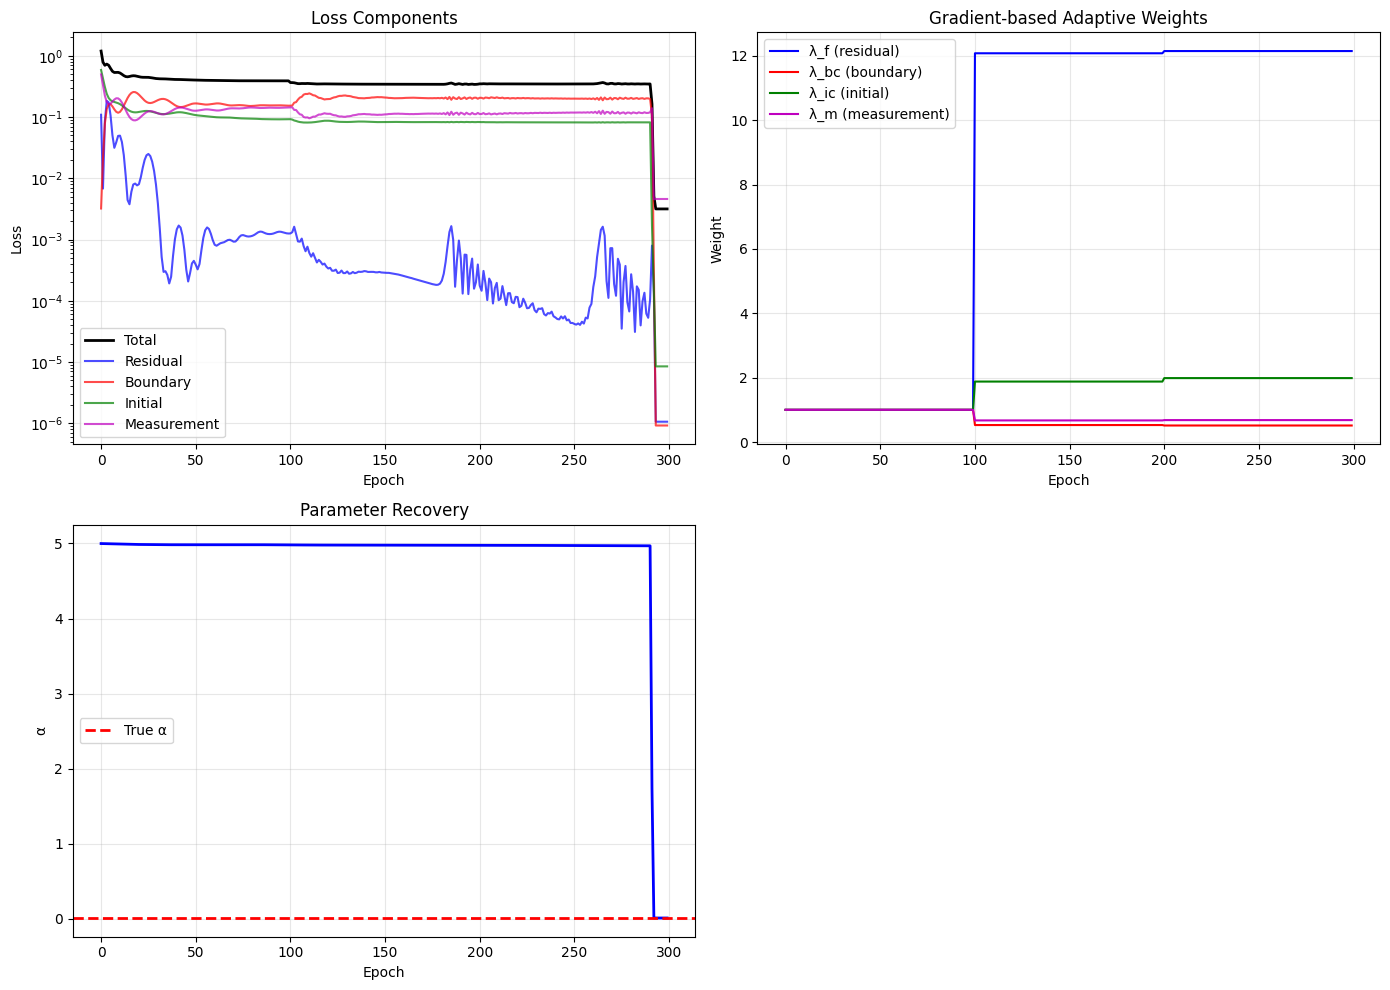


Training complete. Total time: 120.8s


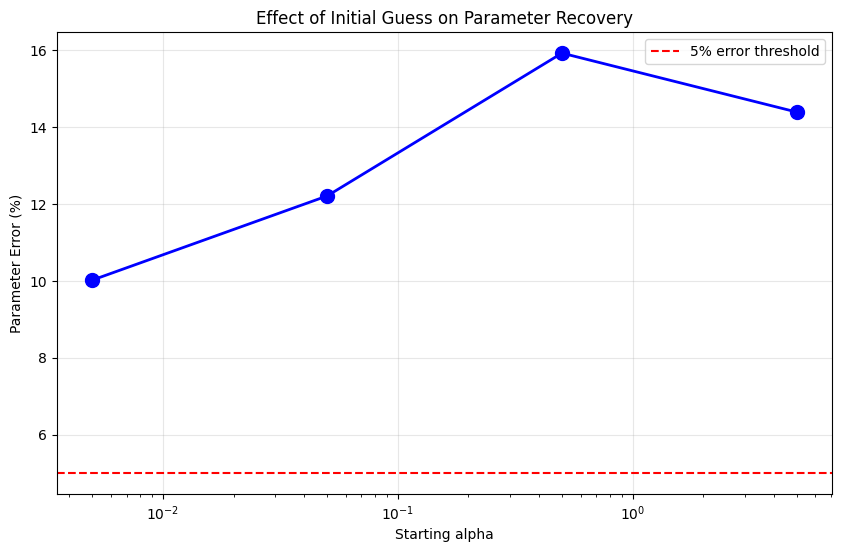

In [20]:
alpha_guesses = [0.005, 0.05, 0.5, 5.0]
results = []

for alpha_guess in alpha_guesses:
    print(f"\nStarting alpha: {alpha_guess:.4f}")
    
    # Train inverse model for 5000 epochs
    model_temp = HeatPINN(inverse=True, alpha_init=alpha_guess)
    trainer_temp = PINNTrainer(model_temp, data_temp, switch_var=0.1, switch_slope=0.001, adaptive_weights=True)
    trainer_temp.train(epochs=5000, print_every=2500, plot_every=5000)

    # Record results
    alpha_recovered = model_temp.get_alpha()
    error = abs(alpha_recovered - 0.01) / 0.01 * 100
    results.append({
        'guess': alpha_guess,
        'alpha': alpha_recovered,
        'error': error
    })

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
guesses = [r['guess'] for r in results]
errors = [r['error'] for r in results]

ax.plot(guesses, errors, 'bo-', markersize=10, linewidth=2)
ax.axhline(y=5, color='r', linestyle='--', label='5% error threshold')
ax.set_xlabel('Starting alpha')
ax.set_ylabel('Parameter Error (%)')
ax.set_title('Effect of Initial Guess on Parameter Recovery')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

### Data requirements

Study the effect of the number of measurements on parameter recovery


Number of sensors: 10.0
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 2 sensors × 5 times = 10 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.33333333 0.66666667]
  Time points: [0.   0.25 0.5  0.75 1.  ]
  Total measurements: 10
  Actual SNR: 41.8 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.762613e+00
  Residual: 3.763747e-04 (λ=1.00)
  Boundary: 4.342730e-02 (λ=1.00)
  Initial: 7.361268e-01 (λ=1.00)
  Measureme

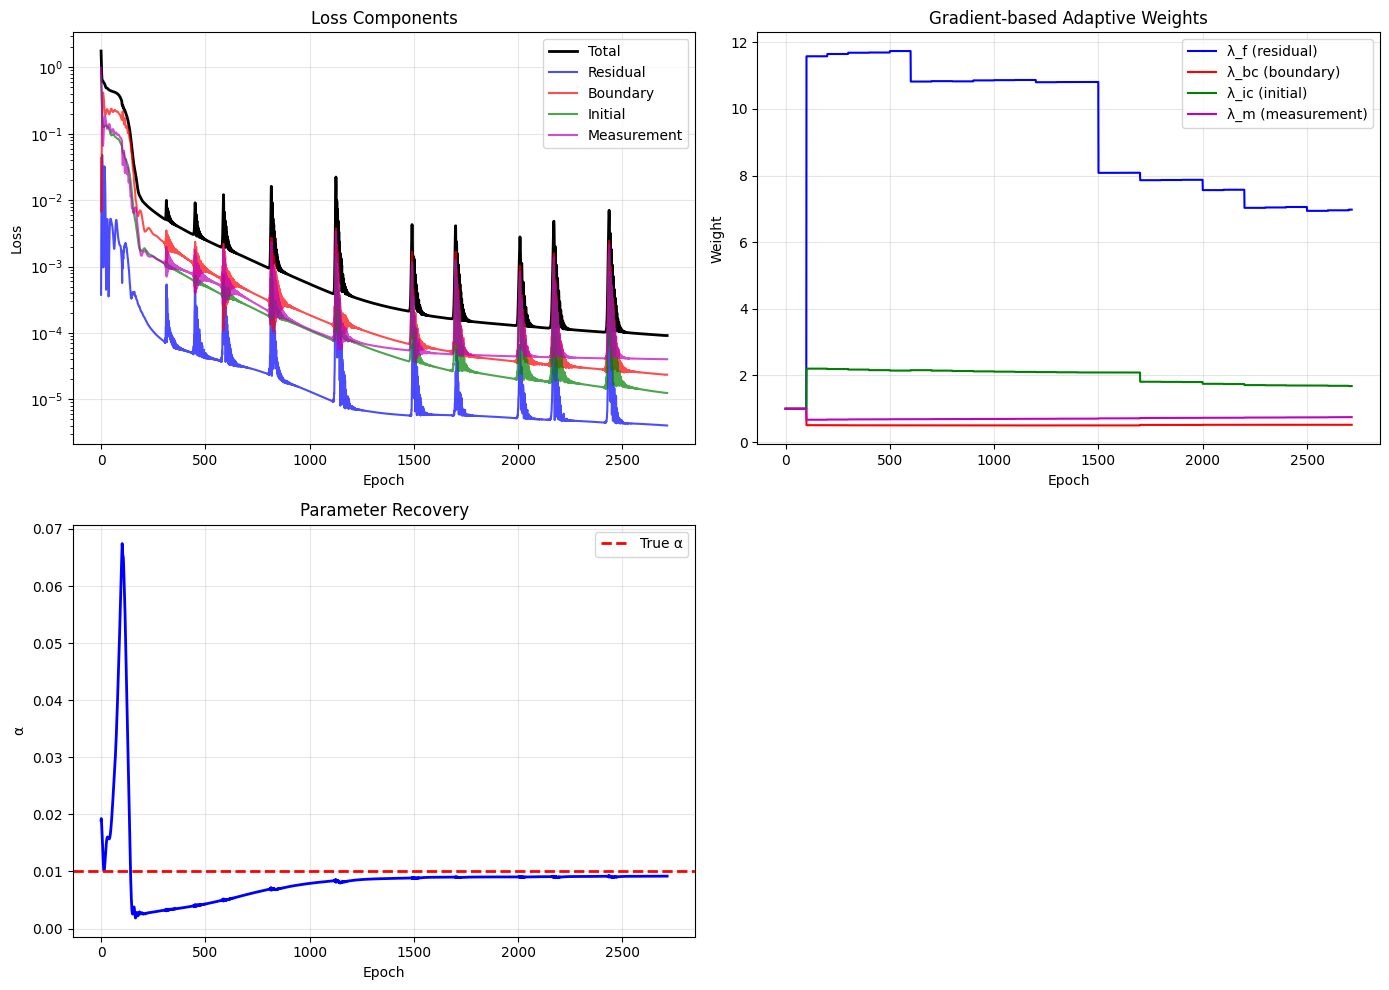


Training complete. Total time: 148.0s


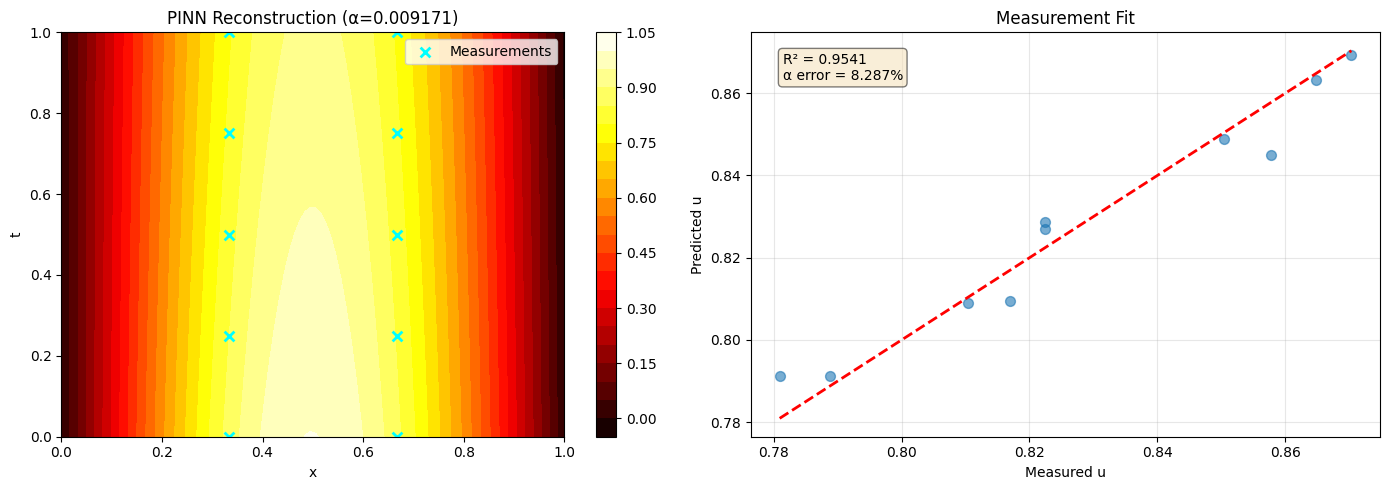


Number of sensors: 25.0
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 5 sensors × 5 times = 25 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.16666667 0.33333333 0.5        0.66666667 0.83333333]
  Time points: [0.   0.25 0.5  0.75 1.  ]
  Total measurements: 25
  Actual SNR: 40.6 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.582355e+00
  Residual: 3.763747e-04 (λ=1.00)
  Boundary: 4.342730e-02 (λ=1.00)
  Initial: 

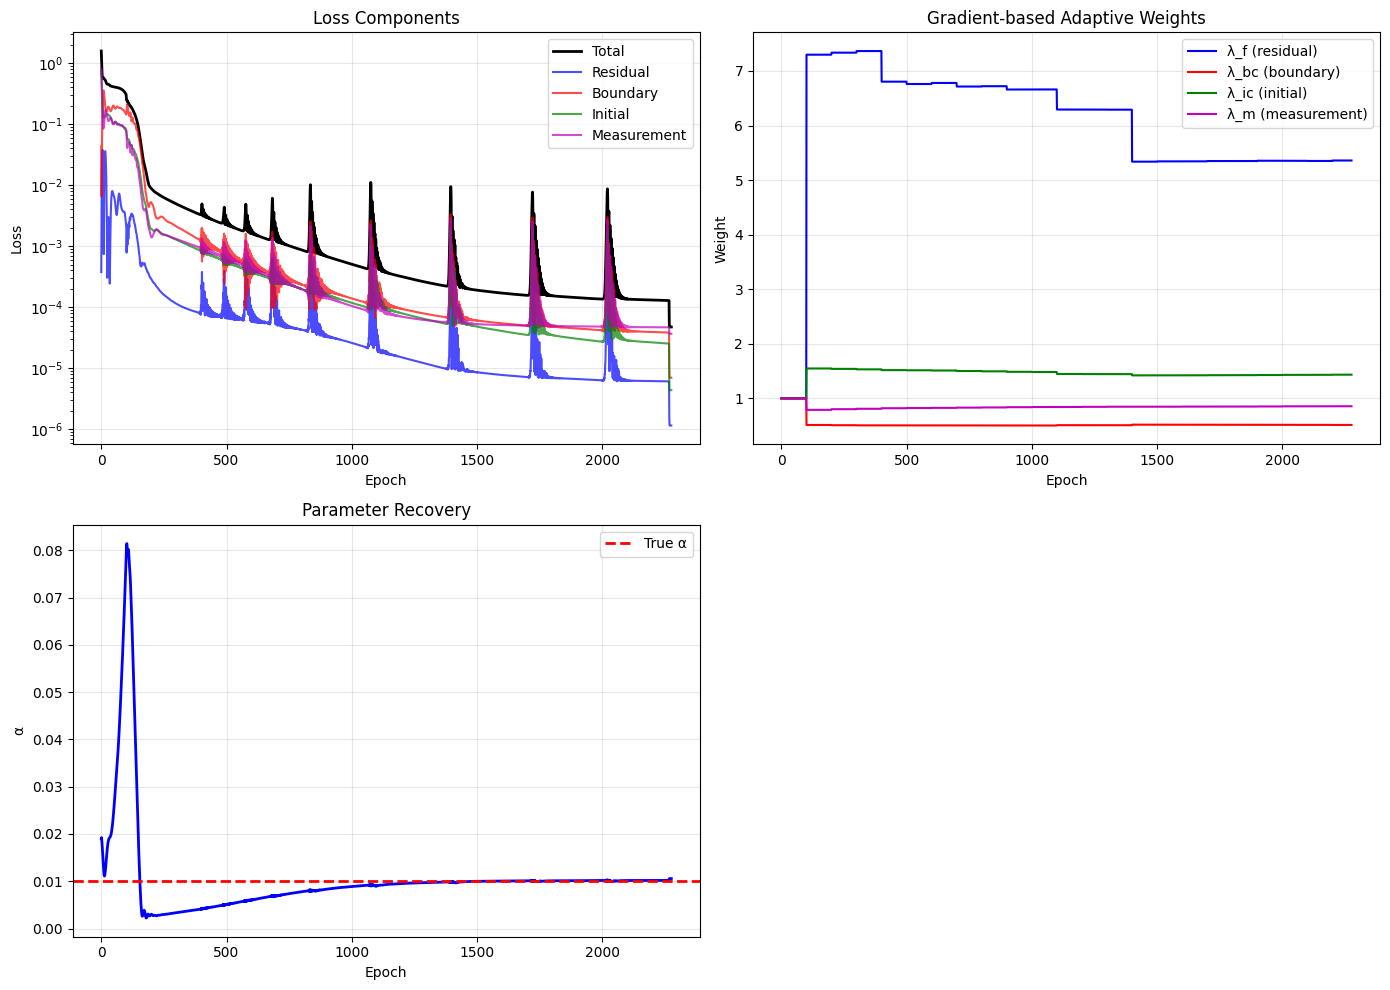


Training complete. Total time: 136.6s


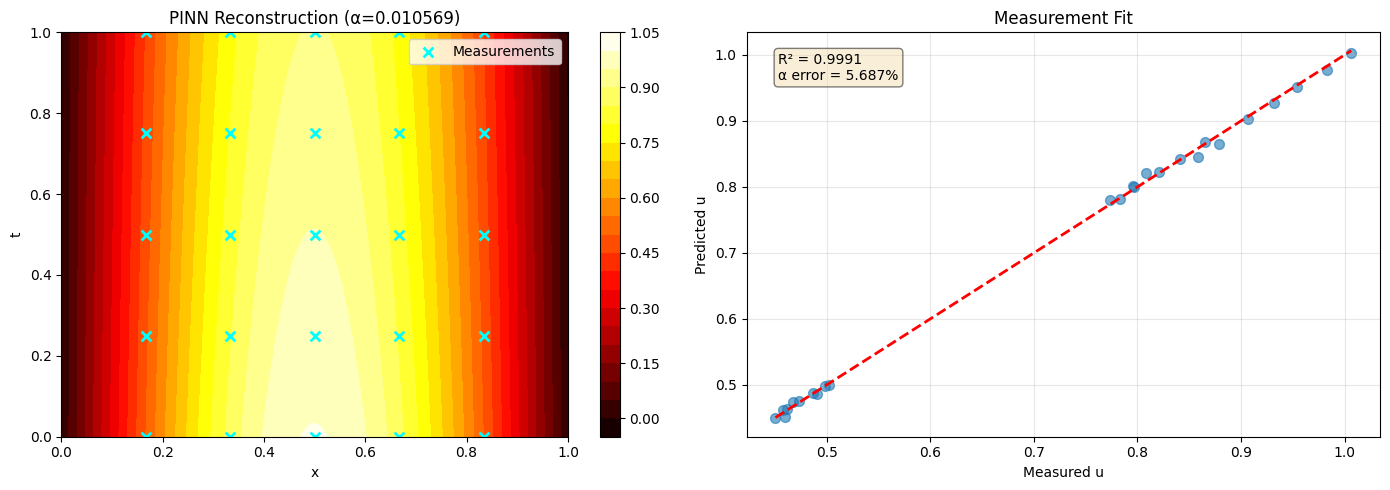


Number of sensors: 50.0
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 5 times = 50 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.   0.25 0.5  0.75 1.  ]
  Total measurements: 50
  Actual SNR: 40.1 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total Loss: 1.519379e+00
  Residual: 3.763747e-

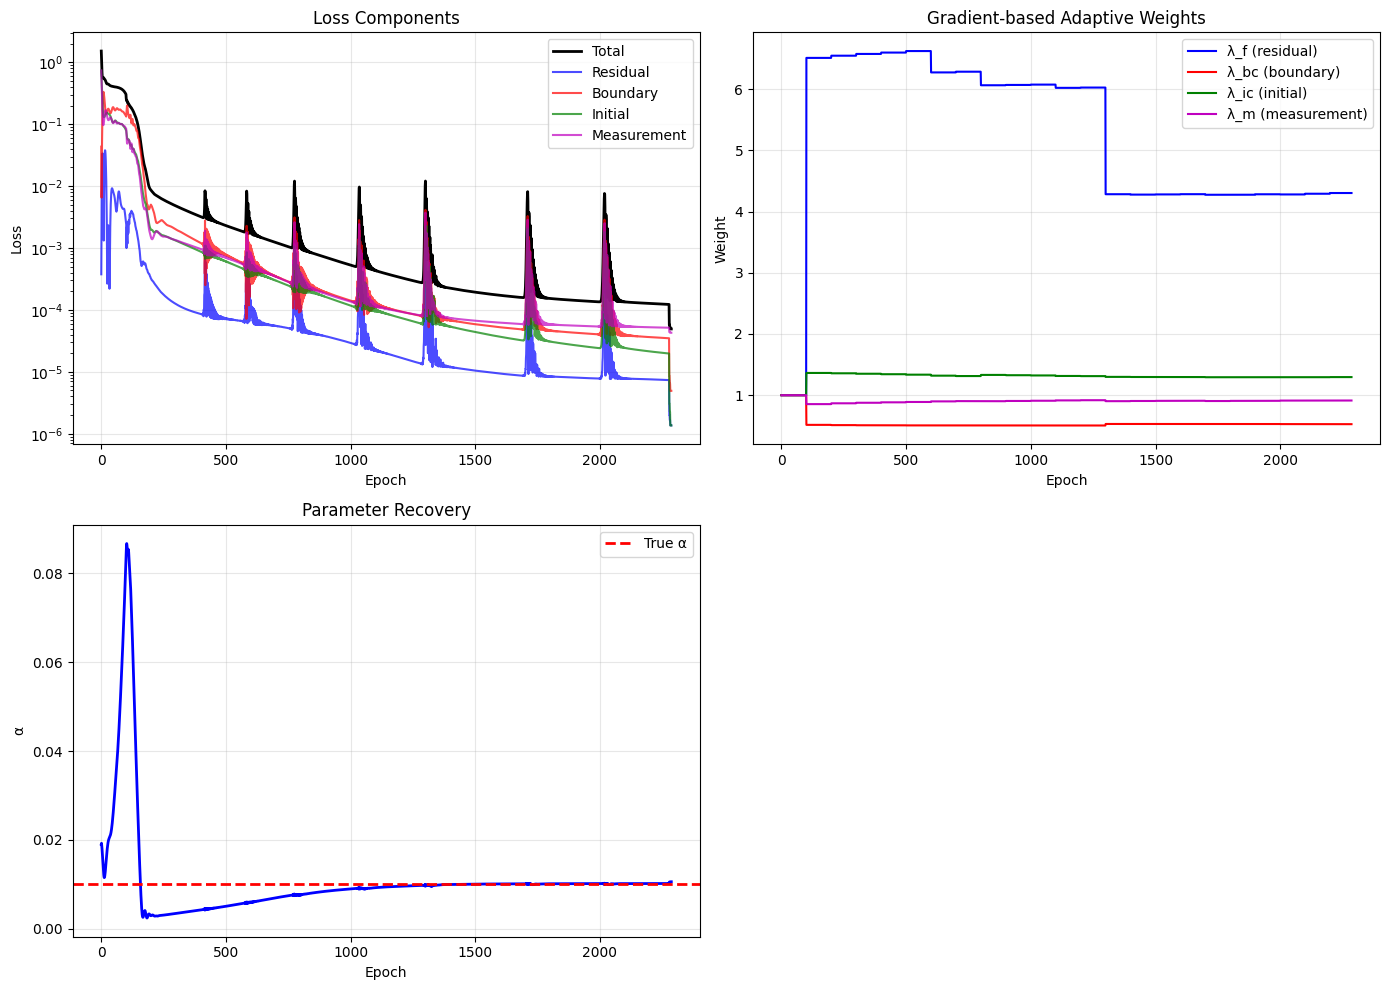


Training complete. Total time: 136.2s


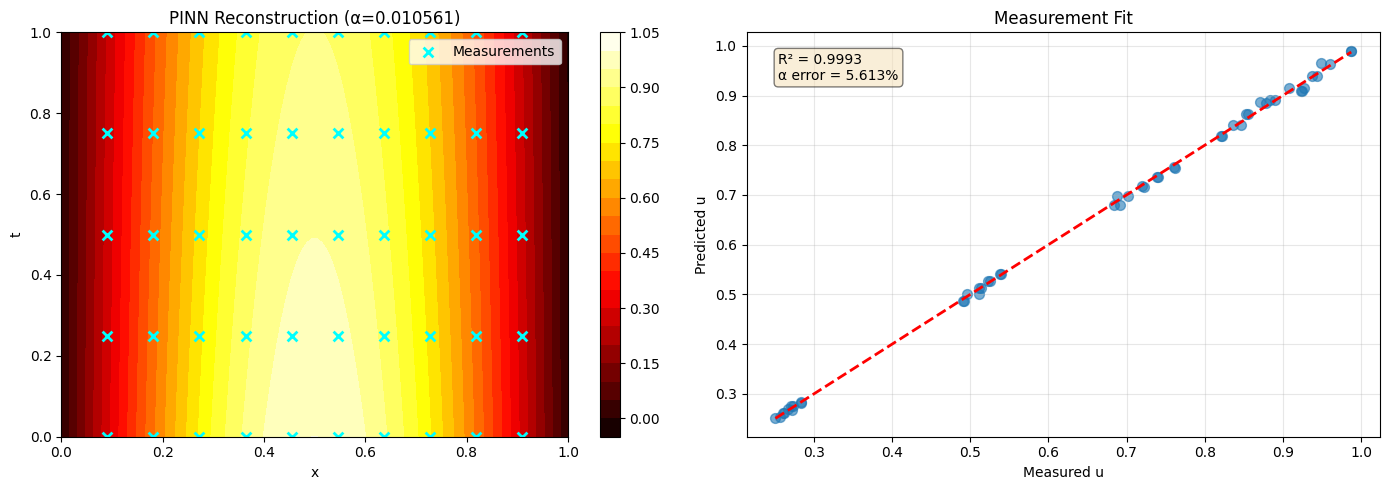


Number of sensors: 100.0
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 20 sensors × 5 times = 100 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.04761905 0.0952381  0.14285714 0.19047619 0.23809524 0.28571429
 0.33333333 0.38095238 0.42857143 0.47619048 0.52380952 0.57142857
 0.61904762 0.66666667 0.71428571 0.76190476 0.80952381 0.85714286
 0.9047619  0.95238095]
  Time points: [0.   0.25 0.5  0.75 1.  ]
  Total measurements: 100
  Actual SNR: 40.8 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Loss variation for L-BFGS switch: 0.1
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Startin

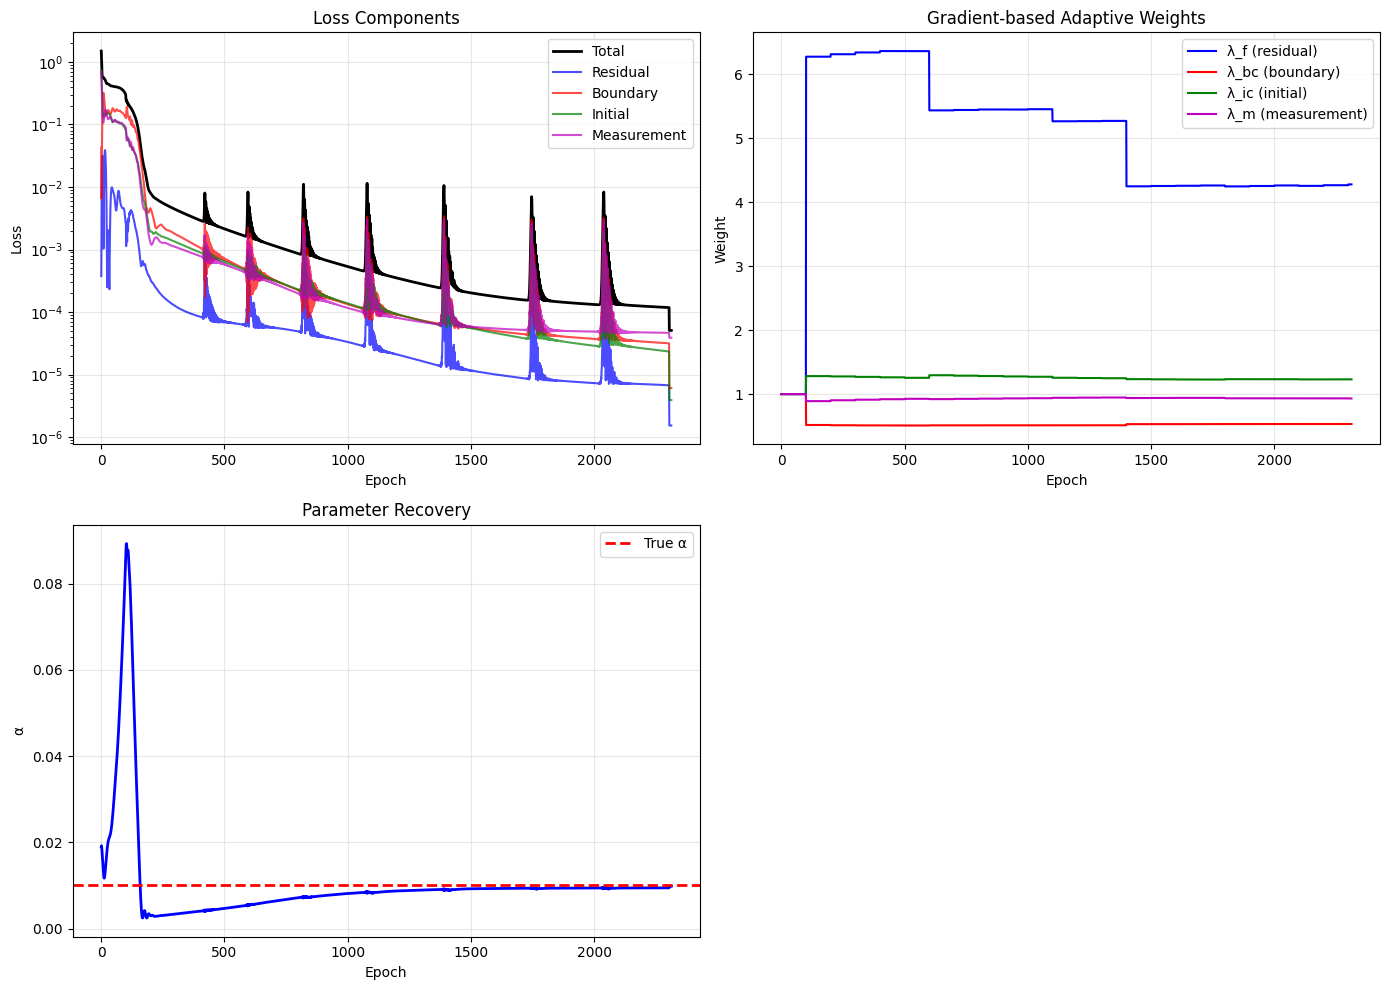


Training complete. Total time: 135.3s


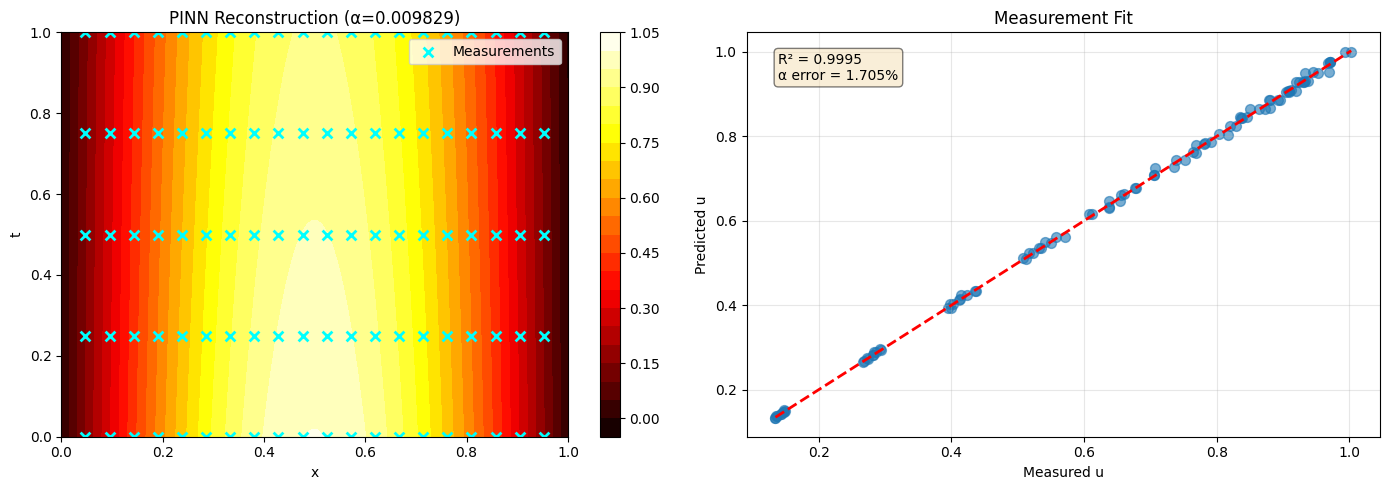

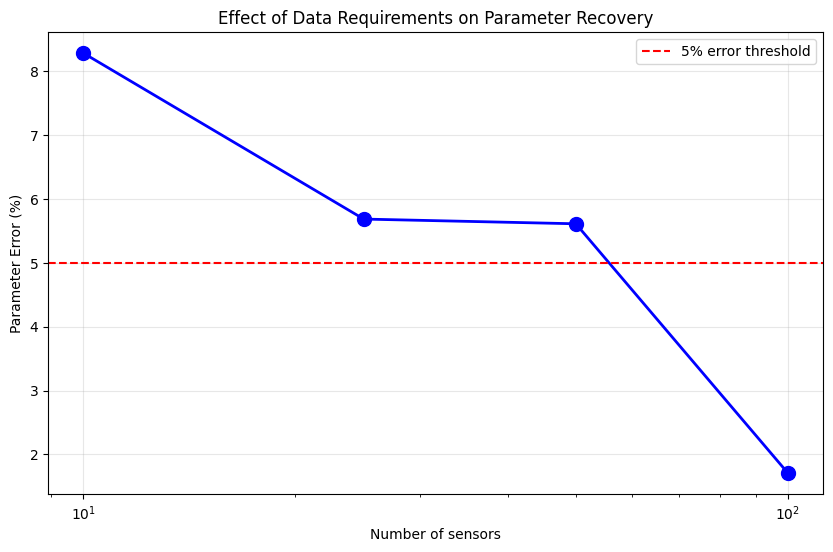

In [ ]:
x_sensors = [2, 5, 10, 20]  # varying amount of sensors along x
t_sensors = 5               # fixed time sensors
results = []

for sensor in x_sensors:
    print(f"\nNumber of sensors: {sensor * t_sensors:.1f}")
    
    # Generate new data with different measurements
    data_gen_temp = HeatEquationData(
        N_f=10000, 
        N_bc=100,
        N_ic=200,
        N_sensors=sensor,
        N_time_measurements=t_sensors,
        noise_level=0.01, 
        device='cpu'
    )
    data_temp = data_gen_temp.generate_full_dataset()
    
    # Train inverse model for 5000 epochs
    model_temp = HeatPINN(inverse=True, alpha_init=0.02)
    trainer_temp = PINNTrainer(model_temp, data_temp, switch_var=0.1, switch_slope=0.001, adaptive_weights=True)
    trainer_temp.train(epochs=5000, print_every=2500, plot_every=5000)
    
    # Record results
    alpha_recovered = model_temp.get_alpha()
    error = abs(alpha_recovered - 0.01) / 0.01 * 100
    results.append({
        'n_sensors': sensor * t_sensors,
        'alpha': alpha_recovered,
        'error': error
    })

    # Plot reconstructed solution
    plot_solution(model_temp, data_temp, alpha_true=0.01, save_path=f'../results/inverse_5k_aw_lbfgs_{sensor}_xsensors_reconstruct.png')

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
n_sensors = [r['n_sensors'] for r in results]
errors = [r['error'] for r in results]

ax.plot(n_sensors, errors, 'bo-', markersize=10, linewidth=2)
ax.axhline(y=5, color='r', linestyle='--', label='5% error threshold')
ax.set_xlabel('Number of sensors')
ax.set_ylabel('Parameter Error (%)')
ax.set_title('Effect of Data Requirements on Parameter Recovery')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()